# Spectrogram Emotion Prototype Learning

*Code fully written by Daniel Peña Porras*.



---


*    #### Post-training **PROTOTYPE ANALYSIS**



---


In [ ]:
'''
@author: Daniel Peña Porras.
'''

##### Dependencies

In [ ]:
from collections import defaultdict

from scipy.stats import skew, kurtosis
from collections import defaultdict
from collections import Counter

In [ ]:
from itertools import product
from tqdm import tqdm

In [ ]:
! pip install librosa
! pip install mir_eval

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

2025-10-03 09:23:54.071663: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
import os

import librosa
import librosa.display as dsp

import mir_eval

# import cv2

from IPython.display import Audio
from scipy.io import wavfile

import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
import soundfile as sf

In [ ]:
!pip install reportlab

In [ ]:
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Image, Preformatted
from reportlab.lib.styles import getSampleStyleSheet
import datetime

from reportlab.platypus import Spacer
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from reportlab.lib.utils import ImageReader

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import io
from PIL import Image

##### Hyperparameters

In [ ]:
"""
DATA PARAMETERS
"""
#prepocess_window_size_ms = 100
#preprocess_window_overlapping_ms = 20
test_prctg = 0.3

dataset = 'EmoMatch' # or 'EmoDB' 'RAVDESS'

dtype = 'float32'
n_frames_cnn = None #128 established after data loading
n_freq_cnn = None #20 established after data loading
n_color_channels = 1

#same parameters as in preprocessing
n_fft = 1024            # length of the FFT window
window = 'hamming'      # window function
win_length = 512        # window length
hop_length = 256        # number of samples between successive frames
n_mels = 128

In [ ]:
if dataset == 'RAVDESS':
    sr = 48000
    n_speakers = 24
    complete_speakers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    n_phonemes = 44
    n_classes = 8
    class_names = [
        'neutral',
        'calm',
        'happy',
        'sad',
        'angry',
        'fearful',
        'disgust',
        'surprised'
    ]
    get_prototype_emotion = {
        0: 'neutral',
        1: 'calm',
        2: 'joy',
        3: 'sadness',
        4: 'anger',
        5: 'fear',
        6: 'disgust',
        7: 'surprise'
    }
    male_speakers = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
    female_speakers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]

elif dataset == 'EmoMatch':
    sr = 48000
    # n_speakers = 50
    speakers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 22, 23,
                25, 29, 31, 33, 35, 36, 37, 40, 41, 43, 45, 46, 49]
    n_speakers = len(n_speakers)
    n_phonemes = 24
    n_classes = 7
    class_names = [
        'angry',
        'disgust',
        'fearful',
        'happy',
        'neutral',
        'sad',
        'surprised'
    ]
    get_prototype_emotion = {
        0: 'anger',
        1: 'disgust',
        2: 'fear',
        3: 'joy',
        4: 'neutral',
        5: 'sadness',
        6: 'surprise'
    }
    male_speakers = [1, 2, 5, 9, 12, 13, 22, 23, 31, 35, 36, 37, 43]
    female_speakers = [3, 4, 6, 7, 8, 10, 11, 20, 25, 29, 33, 40, 41, 45, 46, 49]

elif dataset == 'EmoDB':
    sr = 16000
    n_speakers = 10
    speakers = [3, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    n_phonemes = 45
    n_classes = 7
    class_names = [
        'angry',
        'bored',
        'disgust',
        'fearful',
        'happy',
        'neutral',
        'sad'
    ]
    get_prototype_emotion = {
        0: 'angry',
        1: 'bored',
        2: 'disgust',
        3: 'fearful',
        4: 'happy',
        5: 'neutral',
        6: 'sad'
    }
    male_speakers = [3, 10, 11, 12, 15]
    female_speakers = [8, 9, 13, 14, 16]

fmax = sr/2
fmin = 0  # default value if not specified

In [ ]:
"""
PROTOTYPE-LEARNING CLASSIFIER HYPERPARAMETERS
"""

n_prototypes = n_phonemes * n_classes

##### Functions

In [ ]:
mel_bin_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)

In [ ]:
def get_mean_prototype_score(weights_transposed, scoring_method=2):

  if scoring_method == 0:
    new_weights = weights
    positive_sums = np.sum(np.maximum(new_weights, 0), axis=1)

    for i, row in enumerate(new_weights):
      if positive_sums[i] > 0:
        row[row < 0] = 0  # Set negative values to 0
        row[row > 0] = (row[row > 0] / positive_sums[i]) * 100
      else:
        row[:] = 0
    new_weights_aux = new_weights
    custom_accuracies = np.array([np.max(row) for row in new_weights])

  elif scoring_method == 1:
    new_weights = weights
    new_weights_aux = np.zeros_like(new_weights)
    for i, row in enumerate(new_weights):
      min_val = np.min(row)
      shifted_row = row - min_val  # desplazamos para que el mínimo sea 0
      sum_shifted = np.sum(shifted_row)
      if sum_shifted > 0:
        new_row = (shifted_row / sum_shifted) * 100  # normalizamos y pasamos a %
      else:
        new_row = np.zeros_like(row)  # si todo es constante, ponemos 0
      new_weights_aux[i] = new_row
    custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

  elif scoring_method == 2:
    new_weights = weights
    new_weights_aux = np.zeros_like(new_weights, dtype=float)
    for i, row in enumerate(new_weights):
      # shift logits for numerical stability
      exp_row = np.exp(row - np.max(row))
      softmax_row = exp_row / np.sum(exp_row)
      new_weights_aux[i] = softmax_row * 100  # convert to %
    custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

  mean_custom_accuracy = np.mean(custom_accuracies) * 0.01
  return mean_custom_accuracy

In [ ]:
NOTE_FREQUENCIES = {
    'C': [16.35, 32.70, 65.41, 130.81, 261.63, 523.25, 1046.50, 2093.00, 4186.01],
    'C#/Db': [17.32, 34.65, 69.30, 138.59, 277.18, 554.37, 1108.73, 2217.46, 4434.92],
    'D': [18.35, 36.71, 73.42, 146.83, 293.66, 587.33, 1174.66, 2349.32, 4698.63],
    'D#/Eb': [19.45, 38.89, 77.78, 155.56, 311.13, 622.25, 1244.51, 2489.02, 4978.03],
    'E': [20.60, 41.20, 82.41, 164.81, 329.63, 659.25, 1318.51, 2637.02, 5274.04],
    'F': [21.83, 43.65, 87.31, 174.61, 349.23, 698.46, 1396.91, 2793.83, 5587.65],
    'F#/Gb': [23.12, 46.25, 92.50, 185.00, 369.99, 739.99, 1479.98, 2959.96, 5919.91],
    'G': [24.50, 49.00, 98.00, 196.00, 392.00, 783.99, 1567.98, 3135.96, 6271.93],
    'G#/Ab': [25.96, 51.91, 103.83, 207.65, 415.30, 830.61, 1661.22, 3322.44, 6644.88],
    'A': [27.50, 55.00, 110.00, 220.00, 440.00, 880.00, 1760.00, 3520.00, 7040.00],
    'A#/Bb': [29.14, 58.27, 116.54, 233.08, 466.16, 932.33, 1864.66, 3729.31, 7458.62],
    'B': [30.87, 61.74, 123.47, 246.94, 493.88, 987.77, 1975.53, 3951.07, 7902.13]
}

In [ ]:
# Flatten the dictionary into a list of (note, frequency)
NOTE_LIST = [(note, freq) for note, freqs in NOTE_FREQUENCIES.items() for freq in freqs]

In [ ]:
def get_closest_note(freq):
    closest_note = min(NOTE_LIST, key=lambda x: abs(x[1] - freq))
    return f"{closest_note[0]} ({closest_note[1]:.2f} Hz)"

In [ ]:
def get_closest_note_red(freq):
    closest_note = min(NOTE_LIST, key=lambda x: abs(x[1] - freq))
    return f"{closest_note[0]}"

In [ ]:
def savePrototypes(path, prototypes, weights, n_prototypes, n_frames_cnn,
                           n_freq_cnn, epoch, scale, size='small', colorbar=False,
                           emotions_per_rows=False, final=False, y_list=None,
                           fmin=50, fmax=300, add_text=False, only_top_per_class=False,
                           overlay_f0=False):

    if size == 'small':
        fontsize = 16
        fontsizeTitle = 12
    else:
        fontsize = 156
        fontsizeTitle = 128

    # --- compute class assignment and confidences from `weights` ---
    maxs_prctg = []
    vals_prctg = []
    for row_prctg in weights:
        max_index_prctg = int(np.argmax(row_prctg))
        max_value_prctg = float(row_prctg[max_index_prctg])
        maxs_prctg.append(max_index_prctg)
        vals_prctg.append(max_value_prctg)

    # --- Not grouped by emotion: single-row grid of n_prototypes ---
    if not emotions_per_rows:
        size_x = (n_freq_cnn * n_prototypes) / (10 if size == 'small' else 2)
        size_y = n_frames_cnn / (10 if size == 'small' else 2)
        fig = plt.figure(figsize=(size_x, size_y))

        for i in range(n_prototypes):
            ax = plt.subplot(1, n_prototypes, i + 1)
            spect = prototypes[i]
            y = (y_list[i] if (y_list is not None and i < len(y_list)) else None)
            im = None

            if scale == 'Mel':
                # Matches original Mel branch: show the reshaped spectrogram
                plt.imshow(spect.reshape(n_frames_cnn, n_freq_cnn), origin='lower')

            elif scale == 'Hz':
                # Matches original Hz branch: use librosa.display.specshow
                im = librosa.display.specshow(spect,
                                              cmap='viridis',
                                              x_axis='time',
                                              y_axis='mel',
                                              sr=sr,
                                              hop_length=hop_length)

                # Overlay f0 if requested and we have the raw audio for this
                # prototype (exact same pyin call as original f0 function).
                if overlay_f0 and (y is not None):
                    f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                                sr=sr,
                                                                fmin=fmin,
                                                                fmax=fmax,
                                                                hop_length=hop_length,
                                                                frame_length=8192)
                    times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)
                    ax.plot(times, f0, linewidth=2, color='white', label='f0')
                    ax.legend(loc='upper right', fontsize=fontsize)
                    if add_text:
                        f0_clean = f0[~np.isnan(f0)]
                        if len(f0_clean) > 0:
                            mean_f0 = np.mean(f0_clean)
                            f0_text = f'Mean f₀: {mean_f0:.0f} Hz'
                        else:
                            f0_text = 'Mean f₀: --'
                        ax.text(0.5, -0.10, f0_text, fontsize=fontsize-2, ha='center', va='bottom', transform=ax.transAxes)

            # Title: use class assignment computed from weights (same formatting)
            class_name = get_prototype_emotion.get(maxs_prctg[i])
            plt.title(f'{class_name} - {vals_prctg[i]:.2f}%', fontsize=fontsize)

            # Colorbar: only add when requested and when we have a mappable (im)
            if colorbar and i == (n_prototypes - 1) and (im is not None):
                divider = make_axes_locatable(ax)
                cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height])
                plt.colorbar(im, cax=cax, format="%+2.f dB")

            # Axis formatting (keeps identical appearance)
            ax.get_xaxis().set_ticks([])
            ax.set_xlabel('Time', fontsize=fontsize)
            ax.set_ylabel('Hz', fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)

            if i > 0:
                ax.get_yaxis().set_visible(False)

        title = 'Final prototypes' if final else f'Prototypes - Epoch {epoch}'
        plt.suptitle(title, fontsize=fontsizeTitle)
        plt.tight_layout()
        plt.show()
        plt.close()

    # --- Grouped by emotion: each emotion gets its own figure and saved image ---
    else:
        n_classes = len(np.unique(maxs_prctg))

        for class_val in range(n_classes):
            class_name_plot = get_prototype_emotion.get(class_val)
            prototypes_for_class = [proto for proto, max_val in zip(prototypes, maxs_prctg) if max_val == class_val]
            if y_list is not None:
                y_for_class = [y for y, max_val in zip(y_list, maxs_prctg) if max_val == class_val]
            else:
                y_for_class = None

            confidences = [conf for conf, max_val in zip(vals_prctg, maxs_prctg) if max_val == class_val]
            num_prototypes_for_class = len(prototypes_for_class)

            if num_prototypes_for_class == 0:
                # nothing to plot for this class
                continue

            size_x = (n_freq_cnn * num_prototypes_for_class) / (10 if size == 'small' else 2)
            size_y = n_frames_cnn / (10 if size == 'small' else 2)

            fig = plt.figure(figsize=(size_x, size_y))

            for i in range(num_prototypes_for_class):
                ax = plt.subplot(1, num_prototypes_for_class, i + 1)
                spect = prototypes_for_class[i]
                y = (y_for_class[i] if (y_for_class is not None and i < len(y_for_class)) else None)
                im = None

                if scale == 'Mel':
                    plt.imshow(spect.reshape(n_frames_cnn, n_freq_cnn), origin='lower')
                    if colorbar:
                        plt.colorbar(format="%+2.f dB")

                elif scale == 'Hz' and (y is not None):
                    im = librosa.display.specshow(spect,
                                                  cmap='viridis',
                                                  x_axis='time',
                                                  y_axis='mel',
                                                  sr=sr,
                                                  hop_length=hop_length)

                    if overlay_f0:
                        f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                                                    sr=sr,
                                                                    fmin=fmin,
                                                                    fmax=fmax,
                                                                    hop_length=hop_length,
                                                                    frame_length=8192)
                        times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)
                        ax.plot(times, f0, linewidth=2, color='white', label='f0')
                        ax.legend(loc='upper right', fontsize=fontsize)
                        if add_text:
                            f0_clean = f0[~np.isnan(f0)]
                            if len(f0_clean) > 0:
                                mean_f0 = np.mean(f0_clean)
                                f0_text = f'Mean f₀: {mean_f0:.0f} Hz'
                            else:
                                f0_text = 'Mean f₀: --'
                            ax.text(0.5, -0.10, f0_text, fontsize=fontsize-2, ha='center', va='bottom', transform=ax.transAxes)

                ax.set_title(f'{class_name_plot} - {confidences[i]:.2f}%', fontsize=fontsizeTitle)

                if colorbar and i == (num_prototypes_for_class - 1) and (im is not None):
                    divider = make_axes_locatable(ax)
                    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.01, ax.get_position().height])
                    plt.colorbar(im, cax=cax, format="%+2.f dB")

                ax.get_xaxis().set_ticks([])
                ax.set_xlabel('Time', fontsize=fontsize)
                ax.set_ylabel('Hz', fontsize=fontsize)
                plt.xticks(fontsize=fontsize)
                plt.yticks(fontsize=fontsize)

                if i > 0:
                    ax.get_yaxis().set_visible(False)

            # File naming: match existing conventions. If overlay_f0 is True we
            # include f0 / fmin / fmax in the filename (as in your f0 function),
            # otherwise use the class_ prefix used in the other function.
            if overlay_f0:
                if only_top_per_class:
                    fname = f'{path}f0_class_{class_val}_{class_name_plot}_ONLY_TOP_PROTOTYPE_fmin{fmin}_fmax{fmax}.png'
                else:
                    fname = f'{path}f0_class_{class_val}_{class_name_plot}_fmin{fmin}_fmax{fmax}.png'
            else:
                fname = f'{path}class_{class_val}_{class_name_plot}.png'

            plt.savefig(fname)
            plt.close()

In [ ]:
def displayBestNPrototypesPerClass(num, prototypes, weights, freq_dep_dist, n_prototypes, n_frames_enc, n_freq_enc, n_color_enc,
                                   n_frames_cnn, n_freq_cnn, epoch, scale, size='small', colorbar=False, emotions_per_rows=False):
  fontsize = 64
  fontsizeTitle = 46
  maxs_prctg = []
  vals_prctg = []

  encoded_prototypes=prototypes

  for row_prctg in weights:
    max_index_prctg = np.argmax(row_prctg)
    max_value_prctg = row_prctg[max_index_prctg]
    maxs_prctg.append(max_index_prctg)
    vals_prctg.append(max_value_prctg)

  n = n_prototypes
  n_classes = len(np.unique(maxs_prctg))

  if not emotions_per_rows:
    best_prototypes = []
    encoded_best_prototypes = []

    best_prototypes_confidences = []
    best_prototypes_classes = []

    for class_val in range(n_classes):
        class_indices = [i for i, max_val in enumerate(maxs_prctg) if max_val == class_val]
        if class_indices:
            best_index = max(class_indices, key=lambda i: vals_prctg[i])
            best_prototypes.append(prototypes[best_index])
            encoded_best_prototypes.append(encoded_prototypes[best_index])

            best_prototypes_confidences.append(vals_prctg[best_index])
            best_prototypes_classes.append(class_val)

    num_best_prototypes = len(best_prototypes)

    if size == 'small':
        size_x = (n_freq_cnn * num_best_prototypes) / 10
        size_y = n_frames_cnn / 10
    if size == 'big':
        size_x = (n_freq_cnn * num_best_prototypes) / 2
        size_y = n_frames_cnn / 2

    fig = plt.figure(figsize=(size_x, size_y))

    for i in range(num_best_prototypes):
        ax = plt.subplot(1, num_best_prototypes, i + 1)

        if scale == 'Mel':
            im = plt.imshow(best_prototypes[i].reshape(n_frames_cnn, n_freq_cnn), origin='lower')

            class_name = get_prototype_emotion.get(best_prototypes_classes[i])
            #plt.title('Class - {}'.format(class_name), fontsize=fontsize)

            plt.title('{} - {:.2f}%'.format(class_name, best_prototypes_confidences[i]), fontsize=fontsizeTitle)

            if colorbar or i==(num_best_prototypes-1):
              divider = make_axes_locatable(ax)
              #cax = divider.append_axes("right", size="100%", pad=0)
              cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
              plt.colorbar(im, cax=cax, format="%+2.f dB")
              #plt.colorbar(format="%+2.f dB")

        elif scale == 'Hz':
            im = librosa.display.specshow(best_prototypes[i],
                                         cmap='viridis',
                                         x_axis='time',
                                         y_axis='mel',
                                         sr=48000)

            class_name = get_prototype_emotion.get(best_prototypes_classes[i])
            #plt.title('Class - {}'.format(class_name), fontsize=fontsize)

            plt.title('{} - {:.2f}%'.format(class_name, best_prototypes_confidences[i]), fontsize=fontsizeTitle)
            if colorbar or i==(num_best_prototypes-1):
              divider = make_axes_locatable(ax)
              #cax = divider.append_axes("right", size="100%", pad=0)
              cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
              plt.colorbar(im, cax=cax, format="%+2.f dB")
              #plt.colorbar(format="%+2.f dB")

        ax.get_xaxis().set_ticks([])
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel('Hz', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        if i>0:
          ax.get_yaxis().set_visible(False)

    #plt.suptitle('Prototypes - Epoch {}'.format(epoch), fontsize=16)
    plt.show()
    plt.close()

In [ ]:
def saveAudioPrototypes(path, prototypes, weights):
    maxs_prctg = []
    vals_prctg = []

    for row_prctg in weights:
        max_index_prctg = np.argmax(row_prctg)
        max_value_prctg = row_prctg[max_index_prctg]
        maxs_prctg.append(max_index_prctg)
        vals_prctg.append(max_value_prctg)

    y_list = []
    for i, mel_spec in enumerate(prototypes):
        class_name = get_prototype_emotion.get(maxs_prctg[i])
        class_confidence = int(vals_prctg[i])
        audio = mel_to_audio(mel_spec)
        y_list.append(audio)
        wavfile.write(path+f'{class_name} at {class_confidence}.wav', sr, audio)

    return y_list

In [ ]:
def mel_to_audio(mel_spec):
    mel_spec = librosa.db_to_power(mel_spec)
    audio = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr,
                                                 hop_length=hop_length,
                                                 window=window,
                                                 win_length=win_length,
                                                 n_fft=n_fft,
                                                 )
    return audio

In [ ]:
def get_prototype_classes_and_scores(weights):
    """
    Recibe el array (n_prototypes, n_classes)
    Devuelve:
      - classes: clase más probable para cada prototipo
      - scores: score (% de activación) de esa clase
    """
    classes = np.argmax(weights, axis=1)        # shape: (n_prototypes,)
    scores = np.max(weights, axis=1)            # shape: (n_prototypes,)
    return classes, scores

In [ ]:
def get_proto_index_w_protos(prototype, prototypes):
    distances = np.linalg.norm(prototypes - prototype, axis=(1, 2))
    return np.argmin(distances)

In [ ]:
def get_proto_index(prototype):
    distances = np.linalg.norm(prototypes_rescaled - prototype, axis=(1, 2))
    return np.argmin(distances)

In [ ]:
def analyze_prototypes_only_comparison(prototypes, weights):
    classes, scores = get_prototype_classes_and_scores(weights)
    num_prototypes, num_frequencies, num_timesteps = prototypes.shape

    all_mean_curves = []
    all_std_curves = []
    global_means = []
    global_stds = []
    freq_mean_lists = []
    freq_std_lists = []

    for i in range(num_prototypes):
        prototype = prototypes[i]  # (num_frequencies, num_timesteps)

        mean_curve = prototype.mean(axis=0)         # shape: (num_timesteps,)
        std_curve = prototype.std(axis=0)           # shape: (num_timesteps,)

        all_mean_curves.append(mean_curve)
        all_std_curves.append(std_curve)

        global_mean = mean_curve.mean()  # promedio de la media temporal
        global_std = std_curve.mean()    # promedio de la std temporal
        global_means.append(global_mean)
        global_stds.append(global_std)

        freq_means = prototype.mean(axis=1)  # shape: (num_frequencies,)
        freq_stds = prototype.std(axis=1)    # shape: (num_frequencies,)
        freq_mean_lists.append(freq_means)
        freq_std_lists.append(freq_stds)

    all_mean_curves = np.array(all_mean_curves)   # shape: (n_prototypes, num_timesteps)
    all_std_curves = np.array(all_std_curves)     # shape: (n_prototypes, num_timesteps)
    global_means = np.array(global_means)         # shape: (n_prototypes,)
    global_stds = np.array(global_stds)           # shape: (n_prototypes,)
    freq_mean_lists = np.array(freq_mean_lists)   # shape: (n_prototypes, num_frequencies)
    freq_std_lists = np.array(freq_std_lists)     # shape: (n_prototypes, num_frequencies)

    print("\n--- Global Mean and Std Dev of intensity for each prototype ---")
    for i in range(num_prototypes):
        print(f"Prototype {i+1} (Class {get_prototype_emotion[classes[i]]} - {scores[i]:.2f}%): Mean = {global_means[i]:.4f}, Std = {global_stds[i]:.4f}")

    print("\n--- Frequency-wise mean intensity (128 values per prototype) ---")
    for i in range(num_prototypes):
        print(f"Prototype {i+1} (Class {get_prototype_emotion[classes[i]]} - {scores[i]:.2f}%):")
        print(freq_mean_lists[i])

    print("\n--- Frequency-wise std dev intensity (128 values per prototype) ---")
    for i in range(num_prototypes):
        print(f"Prototype {i+1} (Class {get_prototype_emotion[classes[i]]} - {scores[i]:.2f}%):")
        print(freq_std_lists[i])

    for i in range(num_prototypes):
        print(f"\nPrototype {i+1} (Class {get_prototype_emotion[classes[i]]} - {scores[i]:.2f}%) Frequency Band (Hz) vs Mean Intensity:")
        for j in range(len(mel_bin_frequencies) - 1):
            start_freq = mel_bin_frequencies[j]
            end_freq = mel_bin_frequencies[j + 1]
            intensity = freq_mean_lists[i][j]
            print(f"{start_freq:.2f}-{end_freq:.2f} Hz: {intensity:.4f}")

    top_Ns = [10, 5, 2, 1]
    for N in top_Ns:
        print(f"\n--- Top-{N} frequency bands (Hz) per prototype based on mean intensity ---")
        for i in range(num_prototypes):
            freq_means = freq_mean_lists[i]
            top_indices = np.argsort(freq_means)[-N:][::-1]  # Indices of top-N intensities (sorted descending)

            print(f"Prototype {i+1} (Class {get_prototype_emotion[classes[i]]} - {scores[i]:.2f}%):")
            for idx in top_indices:
                if idx < len(mel_bin_frequencies) - 1:
                    start_freq = mel_bin_frequencies[idx]
                    end_freq = mel_bin_frequencies[idx + 1]
                    val = freq_means[idx]
                    print(f"  {start_freq:.2f}-{end_freq:.2f} Hz: {val:.4f}")

    return {
        'mean_curves': all_mean_curves,
        'std_curves': all_std_curves,
        'global_means': global_means,
        'global_stds': global_stds,
        'freq_means': freq_mean_lists,
        'freq_stds': freq_std_lists,
        'classes': classes,
        'scores': scores
    }

In [ ]:
def analyze_pitch_notes(audio_path, sr):
    y, _ = librosa.load(audio_path, sr=sr)

    fmin = 'C2' #'C0'
    fmax = 'B8'

    f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        fmin=librosa.note_to_hz(fmin),
        fmax=librosa.note_to_hz(fmax),
        sr=sr
    )

    # Only keep valid pitch values
    valid_idx = ~np.isnan(f0)
    f0_valid = f0[valid_idx]

    if len(f0_valid) == 0:
        notes = []
    else:
        notes = [str(n) for n in librosa.hz_to_note(f0_valid, octave=True)]

    return f0, notes, voiced_flag

In [ ]:
def analyze_input_class_for_report(x_train, y_train, class_index):
    figures = []
    texts = []

    class_indices = np.argmax(y_train, axis=1)
    samples = x_train[class_indices == class_index]

    if samples.shape[0] == 0:
        return figures, ["No samples found for this class."]

    mean_spectrogram = np.mean(samples, axis=0)
    std_spectrogram = np.std(samples, axis=0)

    # Intensity per frequency bin
    fig1 = plt.figure(figsize=(12, 6))
    for f in range(mean_spectrogram.shape[0]):
        plt.plot(mean_spectrogram[f], alpha=0.3, linewidth=0.7)
    plt.title(f'Input Class {class_index} ({get_prototype_emotion[class_index]}) - Mean Intensity per Frequency Bin')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig1)

    # Mean ± Std Dev
    mean_curve = mean_spectrogram.mean(axis=0)
    std_curve = mean_spectrogram.std(axis=0)
    fig2 = plt.figure(figsize=(12, 5))
    plt.plot(mean_curve, label='Mean', color='blue')
    plt.fill_between(range(mean_curve.shape[0]),
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     color='blue', alpha=0.3, label='± Std. Dev.')
    plt.title(f'Input Class {class_index} ({get_prototype_emotion[class_index]}) - Mean ± Std Dev')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig2)

    global_mean = mean_spectrogram.mean()
    global_std = std_spectrogram.mean()
    texts.append(f"Input Class {class_index} ({get_prototype_emotion[class_index]}): Mean Intensity = {global_mean:.4f}, Std Dev = {global_std:.4f}")

    return figures, texts

In [ ]:
def analyze_prototype_for_report(prototype, proto_index, class_id, score):
    figures = []
    texts = []

    num_frequencies, num_timesteps = prototype.shape

    # Intensity per frequency bin
    fig1 = plt.figure(figsize=(12, 6))
    for f in range(num_frequencies):
        plt.plot(prototype[f], alpha=0.3, linewidth=0.7)
    plt.title(f'Prototype {proto_index + 1} (Class {class_id} ({get_prototype_emotion[class_id]}), Score {score:.2f}%)')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig1)

    # Mean ± Std Dev
    mean_curve = prototype.mean(axis=0)
    std_curve = prototype.std(axis=0)
    fig2 = plt.figure(figsize=(12, 5))
    plt.plot(mean_curve, label='Mean', color='green')
    plt.fill_between(range(num_timesteps),
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     color='green', alpha=0.3, label='± Std. Dev.')
    plt.title(f'Prototype {proto_index + 1} - Mean ± Std Dev')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig2)

    texts.append(f"Prototype {proto_index + 1} (Class {class_id}) Score: {score:.2f}% - Global Mean = {mean_curve.mean():.4f}, Std = {std_curve.mean():.4f}")

    return figures, texts

In [ ]:
def analyze_prototype_for_report(prototype, proto_index, class_id, score, mel_bin_frequencies):
    figures = []
    texts = []
    frequency_analysis = []

    num_frequencies, num_timesteps = prototype.shape

    proto_index = get_proto_index(prototype)

    # Intensity per frequency bin
    fig1 = plt.figure(figsize=(12, 6))
    for f in range(num_frequencies):
        plt.plot(prototype[f], alpha=0.3, linewidth=0.7)
    plt.title(f'Prototype #{proto_index + 1} (Class {class_id} ({get_prototype_emotion[class_id]}), Score {score:.2f}%)')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig1)

    # Mean ± Std Dev
    mean_curve = prototype.mean(axis=0)
    std_curve = prototype.std(axis=0)
    fig2 = plt.figure(figsize=(12, 5))
    plt.plot(mean_curve, label='Mean', color='green')
    plt.fill_between(range(num_timesteps),
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     color='green', alpha=0.3, label='± Std. Dev.')
    plt.title(f'Prototype #{proto_index + 1} (Class {class_id} ({get_prototype_emotion[class_id]}) - Mean ± Std Dev')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig2)

    texts.append(f"Prototype #{proto_index + 1} (Class {class_id} ({get_prototype_emotion[class_id]})) Score: {score:.2f}% - Global Mean = {mean_curve.mean():.4f}, Std = {std_curve.mean():.4f}")

    # Frequency-wise mean intensity
    freq_means = prototype.mean(axis=1)  # shape: (num_frequencies,)

    # Top-N frequencies
    top_Ns = [10, 5, 2, 1]
    for N in top_Ns:
        top_indices = np.argsort(freq_means)[-N:][::-1]
        top_freqs = mel_bin_frequencies[top_indices]
        top_vals = freq_means[top_indices]

        top_lines = [f"Top-{N} frequency bands (Hz) with highest mean intensity:"]
        for freq, val in zip(top_freqs, top_vals):
            top_lines.append(f"  {freq:.2f} Hz: {val:.4f}")
        frequency_analysis.extend(top_lines)

    return figures, texts, frequency_analysis

In [ ]:
def generate_f0_report(prototypes_rescaled, maxs_prctg, vals_prctg, y_list,
                       get_prototype_emotion, n_classes, class_prototype_sets,
                       dataset, speaker, threshold, sr, fmin, fmax, hop_length,
                       num_harmonics=None, pdf_path):

    print("\n=== Starting f₀ Report Generation ===\n")

    class_mean_f0_list = []
    class_std_dev_f0_list = []
    detection_rate_list = []

    # --- Compute mean f₀ per class ---
    for class_val in range(n_classes):
        class_name_plot = get_prototype_emotion.get(class_val)
        prototypes_for_class = [proto for proto, val in zip(prototypes_rescaled, maxs_prctg) if val == class_val]
        y_for_class = [y for y, val in zip(y_list, maxs_prctg) if val == class_val]
        confidences = [conf for conf, val in zip(vals_prctg, maxs_prctg) if val == class_val]

        num_prototypes = len(prototypes_for_class)
        mean_f0_list = []
        detected = undetected = 0

        if num_prototypes > 0:
            for i in range(num_prototypes):
                y = y_for_class[i] if y_list is not None else None
                if y is not None:
                    f0, voiced_flag, voiced_probs = librosa.pyin(
                        y, sr=sr, fmin=fmin, fmax=fmax, frame_length=8192, fill_na=np.nan, hop_length=hop_length
                    )
                    f0_clean = f0[~np.isnan(f0)]
                    if len(f0_clean) > 0:
                        mean_f0 = np.mean(f0_clean)
                        mean_f0_list.append(mean_f0)
                        print(f'Class {class_val} ({class_name_plot}) Prototype {i} - Mean f₀: {mean_f0:.1f} Hz')
                        sound = librosa.tone(mean_f0, duration=2.0, sr=sr)
                        ipd.Audio(sound, rate=sr)
                        detected += 1
                    else:
                        print(f'Class {class_val} ({class_name_plot}) Prototype {i} - Mean f₀: --')
                        mean_f0_list.append(-1)
                        undetected += 1

            class_mean_f0 = np.mean(mean_f0_list)
            class_std_dev_f0 = np.std(mean_f0_list)
            detection_rate = (detected / (detected + undetected)) * 100 if (detected + undetected) > 0 else 0

            class_mean_f0_list.append(class_mean_f0)
            class_std_dev_f0_list.append(class_std_dev_f0)
            detection_rate_list.append(detection_rate)

            print(f'\nClass {class_val} ({class_name_plot}) - '
                  f'Mean f₀: {class_mean_f0:.2f}, Std Dev: {class_std_dev_f0:.2f} (detection rate: {detection_rate:.2f}%)\n')

    # --- Summary per class ---
    print("\n=== Class-wise Summary ===\n")
    for class_val, mean in enumerate(class_mean_f0_list):
        class_name_plot = get_prototype_emotion.get(class_val)
        print(f'Class {class_val} ({class_name_plot}): '
              f'Mean f₀: {mean:.2f} Hz, Std Dev: {class_std_dev_f0_list[class_val]:.2f} '
              f'(detection rate: {detection_rate_list[class_val]:.2f}%)')

    # --- Sorted by mean f₀ ---
    data = [(class_val, class_mean_f0_list[class_val], class_std_dev_f0_list[class_val], detection_rate_list[class_val])
            for class_val in range(len(class_mean_f0_list))]
    data_sorted = sorted(data, key=lambda x: x[1])

    print("\n=== Classes Sorted by Mean f₀ ===\n")
    for class_val, mean, std_dev, detection_rate in data_sorted:
        class_name_plot = get_prototype_emotion.get(class_val)
        print(f'Class {class_val} ({class_name_plot}): '
              f'Mean f₀: {mean:.2f} Hz, Std Dev: {std_dev:.2f} '
              f'(detection rate: {detection_rate:.2f}%)')

    # --- Generate tone sounds ---
    print("\n=== Generating Tone Sounds ===\n")
    output_dir = f"/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/{speaker}/threshold{threshold}/"
    os.makedirs(output_dir, exist_ok=True)

    for class_val, mean in enumerate(class_mean_f0_list):
        class_name_plot = get_prototype_emotion.get(class_val)
        filename = f'{dataset}_threshold_{threshold}_{class_val}_{class_name_plot}_{mean:.2f}Hz.wav'
        tone = librosa.tone(mean, duration=2.0, sr=sr)
        sf.write(os.path.join(output_dir, filename), tone, sr)
        print(f'Class {class_val} ({class_name_plot}): {mean:.2f} Hz → saved as {filename}')

    # --- Create PDF report ---
    print("\n=== Generating PDF Report ===\n")
    image_dir = output_dir
    page_width, page_height = A4
    c = canvas.Canvas(pdf_path, pagesize=A4)

    # Page 1 summary
    y_position = page_height - 90
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, y_position, f"DATASET: {dataset}")
    y_position -= 30
    c.setFont("Helvetica-Bold", 12)
    c.drawString(50, y_position, f"Prototype Score Threshold: {threshold}")
    y_position -= 120

    for class_val, mean in enumerate(class_mean_f0_list):
        class_name_plot = get_prototype_emotion.get(class_val)
        text = f'Class {class_val} ({class_name_plot}) - Mean f₀: {mean:.2f} Hz, Std Dev: {class_std_dev_f0_list[class_val]:.2f}, Detection Rate: {detection_rate_list[class_val]:.2f}%'
        c.setFont("Helvetica", 11)
        c.drawString(50, y_position, text)
        y_position -= 20

    y_position -= 60
    # Sorted by mean f₀
    for class_val, mean, std_dev, detection_rate in data_sorted:
        class_name_plot = get_prototype_emotion.get(class_val)
        text = f'Class {class_val} ({class_name_plot}) - Mean f₀: {mean:.2f} Hz'
        c.setFont("Helvetica", 11)
        c.drawString(50, y_position, text)
        y_position -= 20

    y_position -= 60
    for class_index in sorted(class_prototype_sets.keys()):
        prototypes = class_prototype_sets[class_index]
        num_prototypes = len(prototypes)
        avg_score = np.mean([p[1] for p in prototypes])
        c.setFont("Helvetica", 11)
        c.drawString(50, y_position, f"Class {class_index} ({get_prototype_emotion[class_index]}): {num_prototypes} prototypes, Avg confidence: {avg_score:.2f}%")
        y_position -= 20

    c.showPage()

    # One page per class (image + stats + individual f₀)
    for class_val in range(n_classes):
        class_name = get_prototype_emotion.get(class_val)
        image_filename = f"f0_class_{class_val}_{class_name}_fmin{fmin}_fmax{fmax}.png"
        image_path = os.path.join(image_dir, image_filename)

        # Image page
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, page_height - 50, f"Class {class_val} - {class_name}")

        if os.path.exists(image_path):
            pil_img = Image.open(image_path)
            img_width, img_height = pil_img.size
            max_display_width = page_width - 100
            max_display_height = page_height - 250
            aspect = img_width / img_height
            if img_width > img_height:
                display_width = min(max_display_width, img_width)
                display_height = display_width / aspect
                if display_height > max_display_height:
                    display_height = max_display_height
                    display_width = display_height * aspect
            else:
                display_height = min(max_display_height, img_height)
                display_width = display_height * aspect
                if display_width > max_display_width:
                    display_width = max_display_width
                    display_height = display_width / aspect

            x_img = (page_width - display_width) / 2
            y_img = 200
            img_reader = ImageReader(pil_img)
            c.drawImage(img_reader, x_img, y_img, width=display_width, height=display_height)
        else:
            c.setFont("Helvetica", 12)
            c.setFillColor(colors.red)
            c.drawString(50, page_height - 100, f"[Image not found: {image_path}]")
            c.setFillColor(colors.black)

        c.setFont("Helvetica", 12)
        c.drawString(50, 160, f"Mean f₀: {class_mean_f0_list[class_val]:.2f} Hz")
        c.drawString(50, 140, f"Std Dev: {class_std_dev_f0_list[class_val]:.2f}")
        c.drawString(50, 120, f"Detection Rate: {detection_rate_list[class_val]:.2f}%")

        c.showPage()

        # Individual prototype f₀ page
        c.setFont("Helvetica-Bold", 16)
        c.drawString(50, page_height - 50, f"Class {class_val} - {class_name} - Individual Prototype f₀")
        y_position = page_height - 90
        c.setFont("Helvetica", 11)

        prototypes_for_class = [proto for proto, val in zip(prototypes_rescaled, maxs_prctg) if val == class_val]
        y_for_class = [y for y, val in zip(y_list, maxs_prctg) if val == class_val]

        for i, y in enumerate(y_for_class):
            if y is not None:
                f0, voiced_flag, voiced_probs = librosa.pyin(
                    y, sr=sr, fmin=fmin, fmax=fmax, frame_length=8192, fill_na=np.nan, hop_length=hop_length
                )
                f0_clean = f0[~np.isnan(f0)]
                display_f0 = f'Class {class_val} ({class_name}) Prototype {i} - Mean f₀: {np.mean(f0_clean):.1f} Hz' if len(f0_clean) > 0 else f'Class {class_val} ({class_name}) Prototype {i} - Mean f₀: --'

                if y_position < 80:
                    c.showPage()
                    y_position = page_height - 50
                    c.setFont("Helvetica", 11)

                c.drawString(60, y_position, display_f0)
                y_position -= 20

        c.showPage()

    c.save()
    print(f"\nPDF report saved at: {pdf_path}")
    print("\n=== f₀ Report Generation Complete ===\n")


In [ ]:
def generate_classwise_report(n_classes, class_prototype_sets,
                              get_prototype_emotion, dataset,
                              speaker, mel_bin_frequencies,
                              analyze_input_class_for_report,
                              analyze_prototype_for_report,
                              analyze_prototype_class_for_report,
                              pdf_path):

    report_type = "classwise"

    print("\n=== Starting Classwise Report Generation ===\n")

    with PdfPages(pdf_path) as pdf:

        # --- Title Page ---
        plt.figure(figsize=(11, 8.5))
        plt.axis("off")
        plt.text(0.5, 0.6, "EmoMatch Prototype Analysis", ha="center", va="center", fontsize=28)
        plt.text(0.5, 0.4, "Class-wise comparison of Input Spectrograms, Prototypes, and Averaged Prototypes",
                 ha="center", va="center", fontsize=16)
        pdf.savefig()
        plt.close()
        print("Added title page to report.\n")

        # --- Text Table Summary Page per Class ---
        for class_index in range(n_classes):
            print(f"Processing Class {class_index} ({get_prototype_emotion[class_index]}) - Summary Table")

            # 1. Analyze input class
            _, class_texts = analyze_input_class_for_report(x_train, y_train, class_index)

            # 2. Analyze each prototype
            proto_info_list = []
            if class_index in class_prototype_sets:
                for i, (proto, score) in enumerate(class_prototype_sets[class_index]):
                    _, prototype_texts, _ = analyze_prototype_for_report(
                        proto, i, class_index, score, mel_bin_frequencies
                    )
                    proto_info_list.append((i, prototype_texts))

            # 3. Analyze prototype class summary
            _, proto_class_texts = analyze_prototype_class_for_report(
                class_index, class_prototype_sets[class_index]
            )

            # 4. Build table data
            table_data = [
                ["Class", f"{class_index} ({get_prototype_emotion[class_index]})"],
                ["Input Class Analysis", class_texts],
            ]
            for proto_idx, proto_text in proto_info_list:
                table_data.append(["Prototype Analysis", proto_text])
            table_data.append(["Prototype Class Summary", proto_class_texts])

            # 5. Create figure and table
            fig, ax = plt.subplots(figsize=(11, 8.5))
            ax.axis("off")

            table = ax.table(
                cellText=table_data,
                colLabels=["Description", "Details"],
                cellLoc="left",
                loc="center",
                colWidths=[0.25, 0.75]
            )

            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1.5)

            pdf.savefig(fig)
            plt.close(fig)
            print(f"Added summary table for Class {class_index}.\n")

        # --- Figures Section ---
        print("Adding detailed figures for each class...\n")

        for class_index in range(n_classes):
            class_name = get_prototype_emotion[class_index]
            print(f"Processing Class {class_index} ({class_name}) figures...")

            # 1. Input class figures
            input_figs, _ = analyze_input_class_for_report(x_train, y_train, class_index)
            for fig in input_figs:
                pdf.savefig(fig)
                plt.close(fig)
            print(f"  Added input figures for Class {class_index}.")

            # 2. Prototype figures
            if class_index in class_prototype_sets:
                for i, (proto, score) in enumerate(class_prototype_sets[class_index]):
                    proto_figs, _, freq_texts = analyze_prototype_for_report(
                        proto, i, class_index, score, mel_bin_frequencies
                    )
                    for fig in proto_figs:
                        pdf.savefig(fig)
                        plt.close(fig)
                print(f"  Added prototype figures for Class {class_index}.")

            # 3. Prototype class summary figures
            proto_class_figs, _ = analyze_prototype_class_for_report(
                class_index, class_prototype_sets[class_index]
            )
            for fig in proto_class_figs:
                pdf.savefig(fig)
                plt.close(fig)
            print(f"  Added prototype class summary figures for Class {class_index}.\n")

    print(f"✅ Classwise Report saved to: {pdf_path}\n")
    print("=== Classwise Report Generation Complete ===\n")

In [ ]:
def analyze_prototype_class_for_report(class_index, prototypes_data):
    figures = []
    texts = []

    if len(prototypes_data) == 0:
        return figures, ["No prototypes found for this class."]

    prototypes = np.array([p[0] for p in prototypes_data])

    mean_prototype = np.mean(prototypes, axis=0)
    std_prototype = np.std(prototypes, axis=0)

    fig1 = plt.figure(figsize=(12, 6))
    for f in range(mean_prototype.shape[0]):
        plt.plot(mean_prototype[f], alpha=0.3, linewidth=0.7)
    plt.title(f'Prototype Class {class_index} ({get_prototype_emotion[class_index]}) - Mean Intensity')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig1)

    mean_curve = mean_prototype.mean(axis=0)
    std_curve = mean_prototype.std(axis=0)

    fig2 = plt.figure(figsize=(12, 5))
    plt.plot(mean_curve, label='Mean', color='orange')
    plt.fill_between(range(mean_curve.shape[0]),
                     mean_curve - std_curve,
                     mean_curve + std_curve,
                     color='orange', alpha=0.3, label='± Std. Dev.')
    plt.title(f'Prototype Class {class_index} ({get_prototype_emotion[class_index]}) - Mean ± Std Dev')
    plt.xlabel('Time')
    plt.ylabel('Intensity (dB)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    figures.append(fig2)

    texts.append(f"Prototype Class {class_index} ({get_prototype_emotion[class_index]}): Avg Intensity = {mean_prototype.mean():.4f}, Std Dev = {std_prototype.mean():.4f}")

    return figures, texts

In [ ]:
def generate_prototype_pdf_report_by_class(results, mel_bin_frequencies, class_prototype_sets, output_path):
    mean_curves = results['mean_curves']
    std_curves = results['std_curves']
    global_means = results['global_means']
    global_stds = results['global_stds']
    freq_means = results['freq_means']
    classes = results['classes']
    scores = results['scores']
    num_prototypes = len(global_means)
    top_Ns = [10, 5, 2, 1]
    chunk_size = 64

    with PdfPages(output_path) as pdf:
        # Global summary
        plt.figure(figsize=(8.5, 11))
        plt.axis('off')
        plt.title("Global Mean and Std Dev of Intensity (Class-Ordered)", fontsize=14, weight='bold', pad=20)
        text = ""
        for class_idx in sorted(class_prototype_sets.keys()):
            for proto, score in class_prototype_sets[class_idx]:
                i = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
                text += f"Prototype #{i+1} (Class {classes[i]} ({get_prototype_emotion[classes[i]]}) - {scores[i]:.2f}%): Mean = {global_means[i]:.4f}, Std = {global_stds[i]:.4f}\n"
        plt.text(0.05, 0.95, text, fontsize=10, va='top', family='monospace')
        pdf.savefig()
        plt.close()

        # Detailed prototype reports per class
        for class_idx in sorted(class_prototype_sets.keys()):
            for proto, score in class_prototype_sets[class_idx]:
                i = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
                proto_vals = freq_means[i]
                num_chunks = (len(mel_bin_frequencies) + chunk_size - 1) // chunk_size

                # Chunks: Frequency summaries
                for chunk in range(num_chunks):
                    start = chunk * chunk_size
                    end = min(start + chunk_size, len(mel_bin_frequencies))
                    fig = plt.figure(figsize=(8.5, 11))
                    fig.suptitle(f"Prototype #{i+1} (Class {classes[i]} ({get_prototype_emotion[classes[i]]}) - {scores[i]:.2f}%) - Frequencies {start+1} to {end}", fontsize=14, weight='bold')
                    ax = fig.add_subplot(111)
                    ax.axis('off')
                    chunk_text = "Frequency Band (Hz) vs Mean Intensity:\n"
                    for j in range(start, end):
                        f1 = mel_bin_frequencies[j]
                        f2 = mel_bin_frequencies[j+1] if j+1 < len(mel_bin_frequencies) else f1
                        label = get_closest_note((f1 + f2) / 2)
                        chunk_text += f"{f1:.2f}-{f2:.2f} Hz ({label}): {proto_vals[j]:.4f}\n"
                    ax.text(0.05, 0.95, chunk_text, fontsize=9, va='top', family='monospace')
                    plt.tight_layout(rect=[0, 0, 1, 0.95])
                    pdf.savefig()
                    plt.close()

                # Top-N Frequencies
                fig = plt.figure(figsize=(8.5, 11))
                fig.suptitle(f"Prototype #{i+1} (Class {classes[i]} ({get_prototype_emotion[classes[i]]}) - {scores[i]:.2f}%) - Top Frequencies", fontsize=14, weight='bold')
                for idx, N in enumerate(top_Ns):
                    ax = plt.subplot2grid((2, 2), (idx // 2, idx % 2))
                    top_indices = np.argsort(proto_vals)[-N:][::-1]
                    top_freqs = mel_bin_frequencies[top_indices]
                    top_vals = proto_vals[top_indices]
                    ax.bar([f"{f:.1f} Hz" for f in top_freqs], top_vals, color='steelblue')
                    ax.set_title(f"Top-{N} Frequencies", fontsize=10)
                    ax.set_ylabel("Mean Intensity")
                    ax.tick_params(axis='x', rotation=45)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                pdf.savefig()
                plt.close()

                # Top-N Notes
                fig = plt.figure(figsize=(8.5, 11))
                fig.suptitle(f"Prototype #{i+1} (Class {classes[i]} ({get_prototype_emotion[classes[i]]}) - {scores[i]:.2f}%) - Top Notes", fontsize=14, weight='bold')
                for idx, N in enumerate(top_Ns):
                    ax = plt.subplot2grid((2, 2), (idx // 2, idx % 2))
                    top_indices = np.argsort(proto_vals)[-N:][::-1]
                    top_freqs = mel_bin_frequencies[top_indices]
                    top_vals = proto_vals[top_indices]
                    note_labels = [get_closest_note(f) for f in top_freqs]
                    ax.bar(note_labels, top_vals, color='steelblue')
                    ax.set_title(f"Top-{N} Notes", fontsize=10)
                    ax.set_ylabel("Mean Intensity")
                    ax.tick_params(axis='x', rotation=45)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                pdf.savefig()
                plt.close()

    print(f"\n✅ Ordered class-based PDF saved to: {output_path}")

In [ ]:
def generate_class_summary_top_frequencies(results, mel_bin_frequencies, class_prototype_sets, output_path):
    from collections import Counter

    freq_means = results['freq_means']
    top_k = 10  # Top-K frequencies per prototype to aggregate
    class_freq_counter = defaultdict(Counter)

    for class_idx, protos in class_prototype_sets.items():
        for proto, _ in protos:
            i = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
            proto_vals = freq_means[i]
            top_indices = np.argsort(proto_vals)[-top_k:]
            for idx in top_indices:
                freq = mel_bin_frequencies[idx]
                class_freq_counter[class_idx][freq] += 1

    # Create one page per class
    with PdfPages(output_path) as pdf:
        for class_idx in sorted(class_freq_counter.keys()):
            freq_counts = class_freq_counter[class_idx]
            top_items = freq_counts.most_common(number_of_notes)
            freqs, counts = zip(*top_items) if top_items else ([], [])
            notes = [get_closest_note(f) for f in freqs]
            #labels = [f"{f:.0f} Hz\n({note})" for f, note in zip(freqs, notes)]
            labels = [f"{note}" for f, note in zip(freqs, notes)]

            fig = plt.figure(figsize=(10, 5))
            plt.bar(labels, counts, color='coral', width=0.6)
            plt.title(f"Class {class_idx} ({get_prototype_emotion[class_idx]}) - Most Frequent Top Frequencies", fontsize=14)
            plt.xlabel("Frequency and Note")
            plt.ylabel("Count (Top Appearances)")
            plt.grid(True, axis='y', linestyle='--', alpha=0.6)
            plt.xticks(rotation=45)

            # Add this line to avoid label cutoff
            plt.subplots_adjust(bottom=0.25)

            pdf.savefig()
            plt.close()

    print(f"\n✅ Class-level top frequency summary PDF saved to: {output_path}")

In [ ]:
def extract_notes_from_prototypes(speaker, class_prototype_sets):
    class_notes_dict = defaultdict(list)
    for class_index in sorted(class_prototype_sets.keys()):
        prototypes_data = class_prototype_sets[class_index]
        for idx_within_class, (proto, score) in enumerate(prototypes_data):
        #for proto, _ in prototypes_data:
            global_proto_index = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
            #filename = f'prototype_{global_proto_index}.wav'
            filename = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/audioPrototypes/{get_prototype_emotion[class_index]} at {int(score)}.wav'
            f0, notes, voiced_flag = analyze_pitch_notes(filename, sr)
            voiced_notes = [n for n, v in zip(notes, voiced_flag) if v]
            class_notes_dict[class_index].extend(voiced_notes)
    return class_notes_dict

In [ ]:
def import_and_prune_prototypes_threshold(complete_speakers, threshold = 0.8, only_top_prototype_per_class = False, scoring_method = 0):
    selected_prototypes = []
    selected_weights = []

    for speaker_id in complete_speakers:
        speaker = f"{speaker_id:02d}"

        prototypes_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/prototypes/prototypes_Speaker{speaker}.npz'
        prototypes_package = np.load(prototypes_path)
        prototypes = prototypes_package['prototypes']
        # prototypes_rescaled = prototypes * (max_norm - min_norm) + min_norm

        weights_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/weights/weights_Speaker{speaker}.npz'
        loaded_data = np.load(weights_path)
        weights = loaded_data['weights']
        # weightsAux = loaded_data['weights']

        # prune
        if scoring_method == 0:
            new_weights = weights
            positive_sums = np.sum(np.maximum(new_weights, 0), axis=1)
            for i, row in enumerate(new_weights):
                if positive_sums[i] > 0:
                    row[row < 0] = 0  # Set negative values to 0
                    row[row > 0] = (row[row > 0] / positive_sums[i]) * 100
                else:
                    row[:] = 0
            new_weights_aux = new_weights
            custom_accuracies = np.array([np.max(row) for row in new_weights])

        elif scoring_method == 1:
            new_weights = weights
            new_weights_aux = np.zeros_like(new_weights)
            for i, row in enumerate(new_weights):
                min_val = np.min(row)
                shifted_row = row - min_val  # desplazamos para que el mínimo sea 0
                sum_shifted = np.sum(shifted_row)
                if sum_shifted > 0:
                    new_row = (shifted_row / sum_shifted) * 100  # normalizamos y pasamos a %
                else:
                    new_row = np.zeros_like(row)  # si todo es constante, ponemos 0
                new_weights_aux[i] = new_row
            custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

        elif scoring_method == 2:
            new_weights = weights
            new_weights_aux = np.zeros_like(new_weights, dtype=float)
            for i, row in enumerate(new_weights):
                # shift logits for numerical stability
                exp_row = np.exp(row - np.max(row))
                softmax_row = exp_row / np.sum(exp_row)
                new_weights_aux[i] = softmax_row * 100  # convert to %
            custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

        # Select prototypes and weights based on threshold
        indices = np.where(custom_accuracies >= (threshold * 100))[0]
        selected_prototypes.append(prototypes[indices])
        selected_weights.append(new_weights_aux[indices])

    # Stack the selected items across all speakers
    if selected_prototypes:
        all_selected_prototypes = np.concatenate(selected_prototypes, axis=0)
        all_selected_weights = np.concatenate(selected_weights, axis=0)
    else:
        all_selected_prototypes = np.empty((0,))  # Empty fallback
        all_selected_weights = np.empty((0,))

    return all_selected_prototypes, all_selected_weights

In [ ]:
def import_and_prune_prototypes_top(complete_speakers, topN=10, scoring_method = 0):
    all_prototypes_per_class = defaultdict(list)  # Collects (confidence, prototype, weight) tuples
    all_weights_per_class = defaultdict(list)

    for speaker_id in complete_speakers:
        speaker = f"{speaker_id:02d}"

        # Load prototypes
        prototypes_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/prototypes/prototypes_Speaker{speaker}.npz'
        prototypes_package = np.load(prototypes_path)
        prototypes = prototypes_package['prototypes']

        # Load and normalize weights
        weights_path = f'/home/jovyan/Daniel/Exp_{dataset}/classifiers_training/weights/weights_Speaker{speaker}.npz'
        loaded_data = np.load(weights_path)
        weights = loaded_data['weights']

        # prune
        if scoring_method == 0:
            new_weights = weights
            positive_sums = np.sum(np.maximum(new_weights, 0), axis=1)
            for i, row in enumerate(new_weights):
                if positive_sums[i] > 0:
                    row[row < 0] = 0  # Set negative values to 0
                    row[row > 0] = (row[row > 0] / positive_sums[i]) * 100
                else:
                    row[:] = 0
            new_weights_aux = new_weights
            custom_accuracies = np.array([np.max(row) for row in new_weights])

        elif scoring_method == 1:
            new_weights = weights
            new_weights_aux = np.zeros_like(new_weights)
            for i, row in enumerate(new_weights):
                min_val = np.min(row)
                shifted_row = row - min_val  # desplazamos para que el mínimo sea 0
                sum_shifted = np.sum(shifted_row)
                if sum_shifted > 0:
                    new_row = (shifted_row / sum_shifted) * 100  # normalizamos y pasamos a %
                else:
                    new_row = np.zeros_like(row)  # si todo es constante, ponemos 0
                new_weights_aux[i] = new_row
            custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

        elif scoring_method == 2:
            new_weights = weights
            new_weights_aux = np.zeros_like(new_weights, dtype=float)
            for i, row in enumerate(new_weights):
                # shift logits for numerical stability
                exp_row = np.exp(row - np.max(row))
                softmax_row = exp_row / np.sum(exp_row)
                new_weights_aux[i] = softmax_row * 100  # convert to %
            custom_accuracies = np.array([np.max(row) for row in new_weights_aux])

        # For each prototype, get class with max weight and store it
        for proto, weight_row in zip(prototypes, new_weights_aux):
            class_index = np.argmax(weight_row)
            confidence = weight_row[class_index]
            all_prototypes_per_class[class_index].append((confidence, proto, weight_row))

    # Now pick top-N per class
    final_prototypes = []
    final_weights = []

    for class_index, items in all_prototypes_per_class.items():
        sorted_items = sorted(items, key=lambda x: x[0], reverse=True)  # Sort by confidence
        top_items = sorted_items[:topN]
        for confidence, proto, weight in top_items:
            final_prototypes.append(proto)
            final_weights.append(weight)

    if final_prototypes:
        all_selected_prototypes = np.stack(final_prototypes)
        all_selected_weights = np.stack(final_weights)
    else:
        all_selected_prototypes = np.empty((0,))
        all_selected_weights = np.empty((0,))

    return all_selected_prototypes, all_selected_weights

In [ ]:
def generate_class_summary_top_frequencies_boxplots(results, mel_bin_frequencies, class_prototype_sets, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    freq_means = results['freq_means']  # shape: (num_prototypes, num_frequencies)

    for class_idx, protos in class_prototype_sets.items():
        class_freqs = []

        for proto, _ in protos:
            i = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
            proto_vals = results['freq_means'][i]
            class_freqs.append(proto_vals)

        class_freqs = np.array(class_freqs)  # shape: (num_class_protos, num_frequencies)
        class_freqs = class_freqs.T  # shape: (num_frequencies, num_protos)

        means = np.mean(class_freqs, axis=1)
        medians = np.median(class_freqs, axis=1)
        modes = stats.mode(class_freqs, axis=1).mode[:, 0]

        # Plot
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.boxplot(class_freqs.T, notch=False, patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.4))

        ax.plot(means, label='Mean', color='red', marker='o')
        ax.plot(medians, label='Median', color='blue', linestyle='--', marker='o')
        ax.plot(modes, label='Mode', color='black', linestyle=':', marker='D')

        # ax.set_xticks(np.arange(len(mel_bin_frequencies)))
        # xtick_labels = [f"{int(freq)}" for freq in mel_bin_frequencies]
        # ax.set_xticklabels(xtick_labels, rotation=45, fontsize=8)
        xtick_step = 5  # Show every 10th frequency to reduce clutter
        xtick_indices = np.arange(0, len(mel_bin_frequencies), xtick_step)
        xtick_labels = [f"{int(mel_bin_frequencies[i])}" for i in xtick_indices]

        ax.set_xticks(xtick_indices)
        ax.set_xticklabels(xtick_labels, rotation=45, fontsize=8)

        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Importance / Activation")
        ax.set_title(f"Class {class_idx} ({get_prototype_emotion[class_idx]}) - Frequency Importance Distribution")
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)

        output_file = os.path.join(output_dir, f'boxplot_class_{class_idx}.png')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.close()

        print(f"✅ Boxplot saved to: {output_file}")

In [ ]:
def generate_all_classes_summary_plot(results, mel_bin_frequencies, class_prototype_sets,
                                      output_dir, prototypes_rescaled, freq_range=None, speaker=1):
    os.makedirs(output_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=(16, 7))

    for class_idx, protos in class_prototype_sets.items():
        class_freqs = []
        for proto, _ in protos:
            i = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
            proto_vals = results['freq_means'][i]
            class_freqs.append(proto_vals)

        class_freqs = np.array(class_freqs).T  # shape: (num_frequencies, num_protos)
        means = np.mean(class_freqs, axis=1)

        freqs = mel_bin_frequencies
        if freq_range is not None:
            mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
            freqs, means = freqs[mask], means[mask]

        ax.plot(freqs, means, label=f"Class {class_idx} ({get_prototype_emotion[class_idx]})")

    # ticks
    num_ticks = 15
    xtick_indices = np.linspace(0, len(freqs)-1, num_ticks, dtype=int)
    xtick_positions = freqs[xtick_indices]
    xtick_labels = [f"{int(p)}" for p in xtick_positions]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=8)

    if freq_range is not None:
        ax.set_xlim(freq_range)

    ######################################################################################

    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Importance / Activation")
    ax.set_title(f"Speaker {speaker} - All Classes - Frequency Importance Distribution (Means)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    out = os.path.join(output_dir, "all_boxplot_classes_summary.png")
    plt.tight_layout()
    plt.savefig(out, dpi=300)
    plt.close()
    print("Saved:", out)

In [ ]:
def generate_prototypes_pitch_notes_report(class_prototype_sets,
                                           prototypes_rescaled,
                                           get_prototype_emotion,
                                           analyze_pitch_notes,
                                           dataset, speaker, sr, pdf_path):

    report_type = "prototypes_pitch_notes"

    print("\n=== Starting Prototypes Pitch Notes Report Generation ===\n")

    with PdfPages(pdf_path) as pdf:
        for class_index in sorted(class_prototype_sets.keys()):
            class_name = get_prototype_emotion[class_index]
            prototypes_data = class_prototype_sets[class_index]
            print(f"Processing Class {class_index} ({class_name}) with {len(prototypes_data)} prototypes...")

            for idx_within_class, (proto, score) in enumerate(prototypes_data):
                # Identify prototype index in global array
                try:
                    global_proto_index = np.where((prototypes_rescaled == proto).all(axis=(1, 2)))[0][0]
                except IndexError:
                    print(f"⚠️ Warning: Prototype not found in prototypes_rescaled for class {class_index}")
                    global_proto_index = -1

                # Define prototype audio filename
                filename = (
                    f"/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/Speaker{speaker}/audioPrototypes/"
                    f"{class_name} at {int(score)}.wav"
                )

                # Analyze pitch and notes
                f0, notes, voiced_flag = analyze_pitch_notes(filename, sr)
                voiced_notes = [n for n, v in zip(notes, voiced_flag) if v]
                f0_valid = f0[~np.isnan(f0)]
                times = librosa.times_like(f0)

                # --- Plotting ---
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, f0, label="Pitch (f₀)", color="blue")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Frequency (Hz)")
                ax.grid(True)

                title_str = (
                    f"Prototype #{global_proto_index + 1 if global_proto_index >= 0 else '?'} "
                    f"(Class {class_index} - {class_name}, {score:.2f}%) - Pitch Track"
                )
                ax.set_title(title_str)

                if len(f0_valid) > 0:
                    f0_max = np.max(f0_valid)
                    ax.set_ylim(top=f0_max + 20)

                # Annotate musical notes on the plot
                step = max(1, len(times) // 30)
                for t, f, note, v in zip(times[::step], f0[::step], voiced_notes[::step], voiced_flag[::step]):
                    if v and not np.isnan(f):
                        ax.text(t, f + 5, note, fontsize=8, ha="center", color="darkred")

                # Text summary of notes
                notes_text = "Detected notes:\n" + ", ".join(voiced_notes)
                plt.figtext(0.5, -0.15, notes_text, wrap=True, ha="center", fontsize=9)

                pdf.savefig(fig, bbox_inches="tight")
                plt.close(fig)

                print(f"  → Saved prototype #{global_proto_index + 1 if global_proto_index >= 0 else '?'} "
                      f"({class_name}, {score:.2f}%) to report.")

    print(f"\n✅ {report_type} PDF report saved as: {pdf_path}")
    print("\n=== Prototypes Pitch Notes Report Generation Complete ===\n")

In [ ]:
def print_weights(weights):
    for i in range(len(weights)):
        for j in range(len(weights[0])):
            print(f"{weights[i][j]:.2f}", end="\t")
        print()

In [ ]:
def generate_harmonic_tone(f0, duration=2.0, sr=22050, num_harmonics=5, decay=0.5, filename='harmonic_tone.wav'):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)

    y = np.zeros_like(t)

    for n in range(1, num_harmonics + 1):
        amplitude = decay ** (n - 1)  # geometric decay: 1, 0.5, 0.25, ...
        harmonic = amplitude * np.sin(2 * np.pi * f0 * n * t)
        y += harmonic

    y /= np.max(np.abs(y))  # normalize to [-1, 1]

    return ipd.Audio(y, rate=sr)

## **Analysis**

In [ ]:
method = 'threshold' #'top'
if method == 'threshold':
  threshold = 0.99
elif method == 'top':
  topN = 10

In [ ]:
fmin = 50
fmax = 300



🔁 Analyzing Prototypes of Speaker 07...
Number of prototypes:  70
class anger : 10 prototypes
class disgust : 10 prototypes
class fear : 10 prototypes
class joy : 10 prototypes
class neutral : 10 prototypes
class sadness : 10 prototypes
class surprise : 10 prototypes


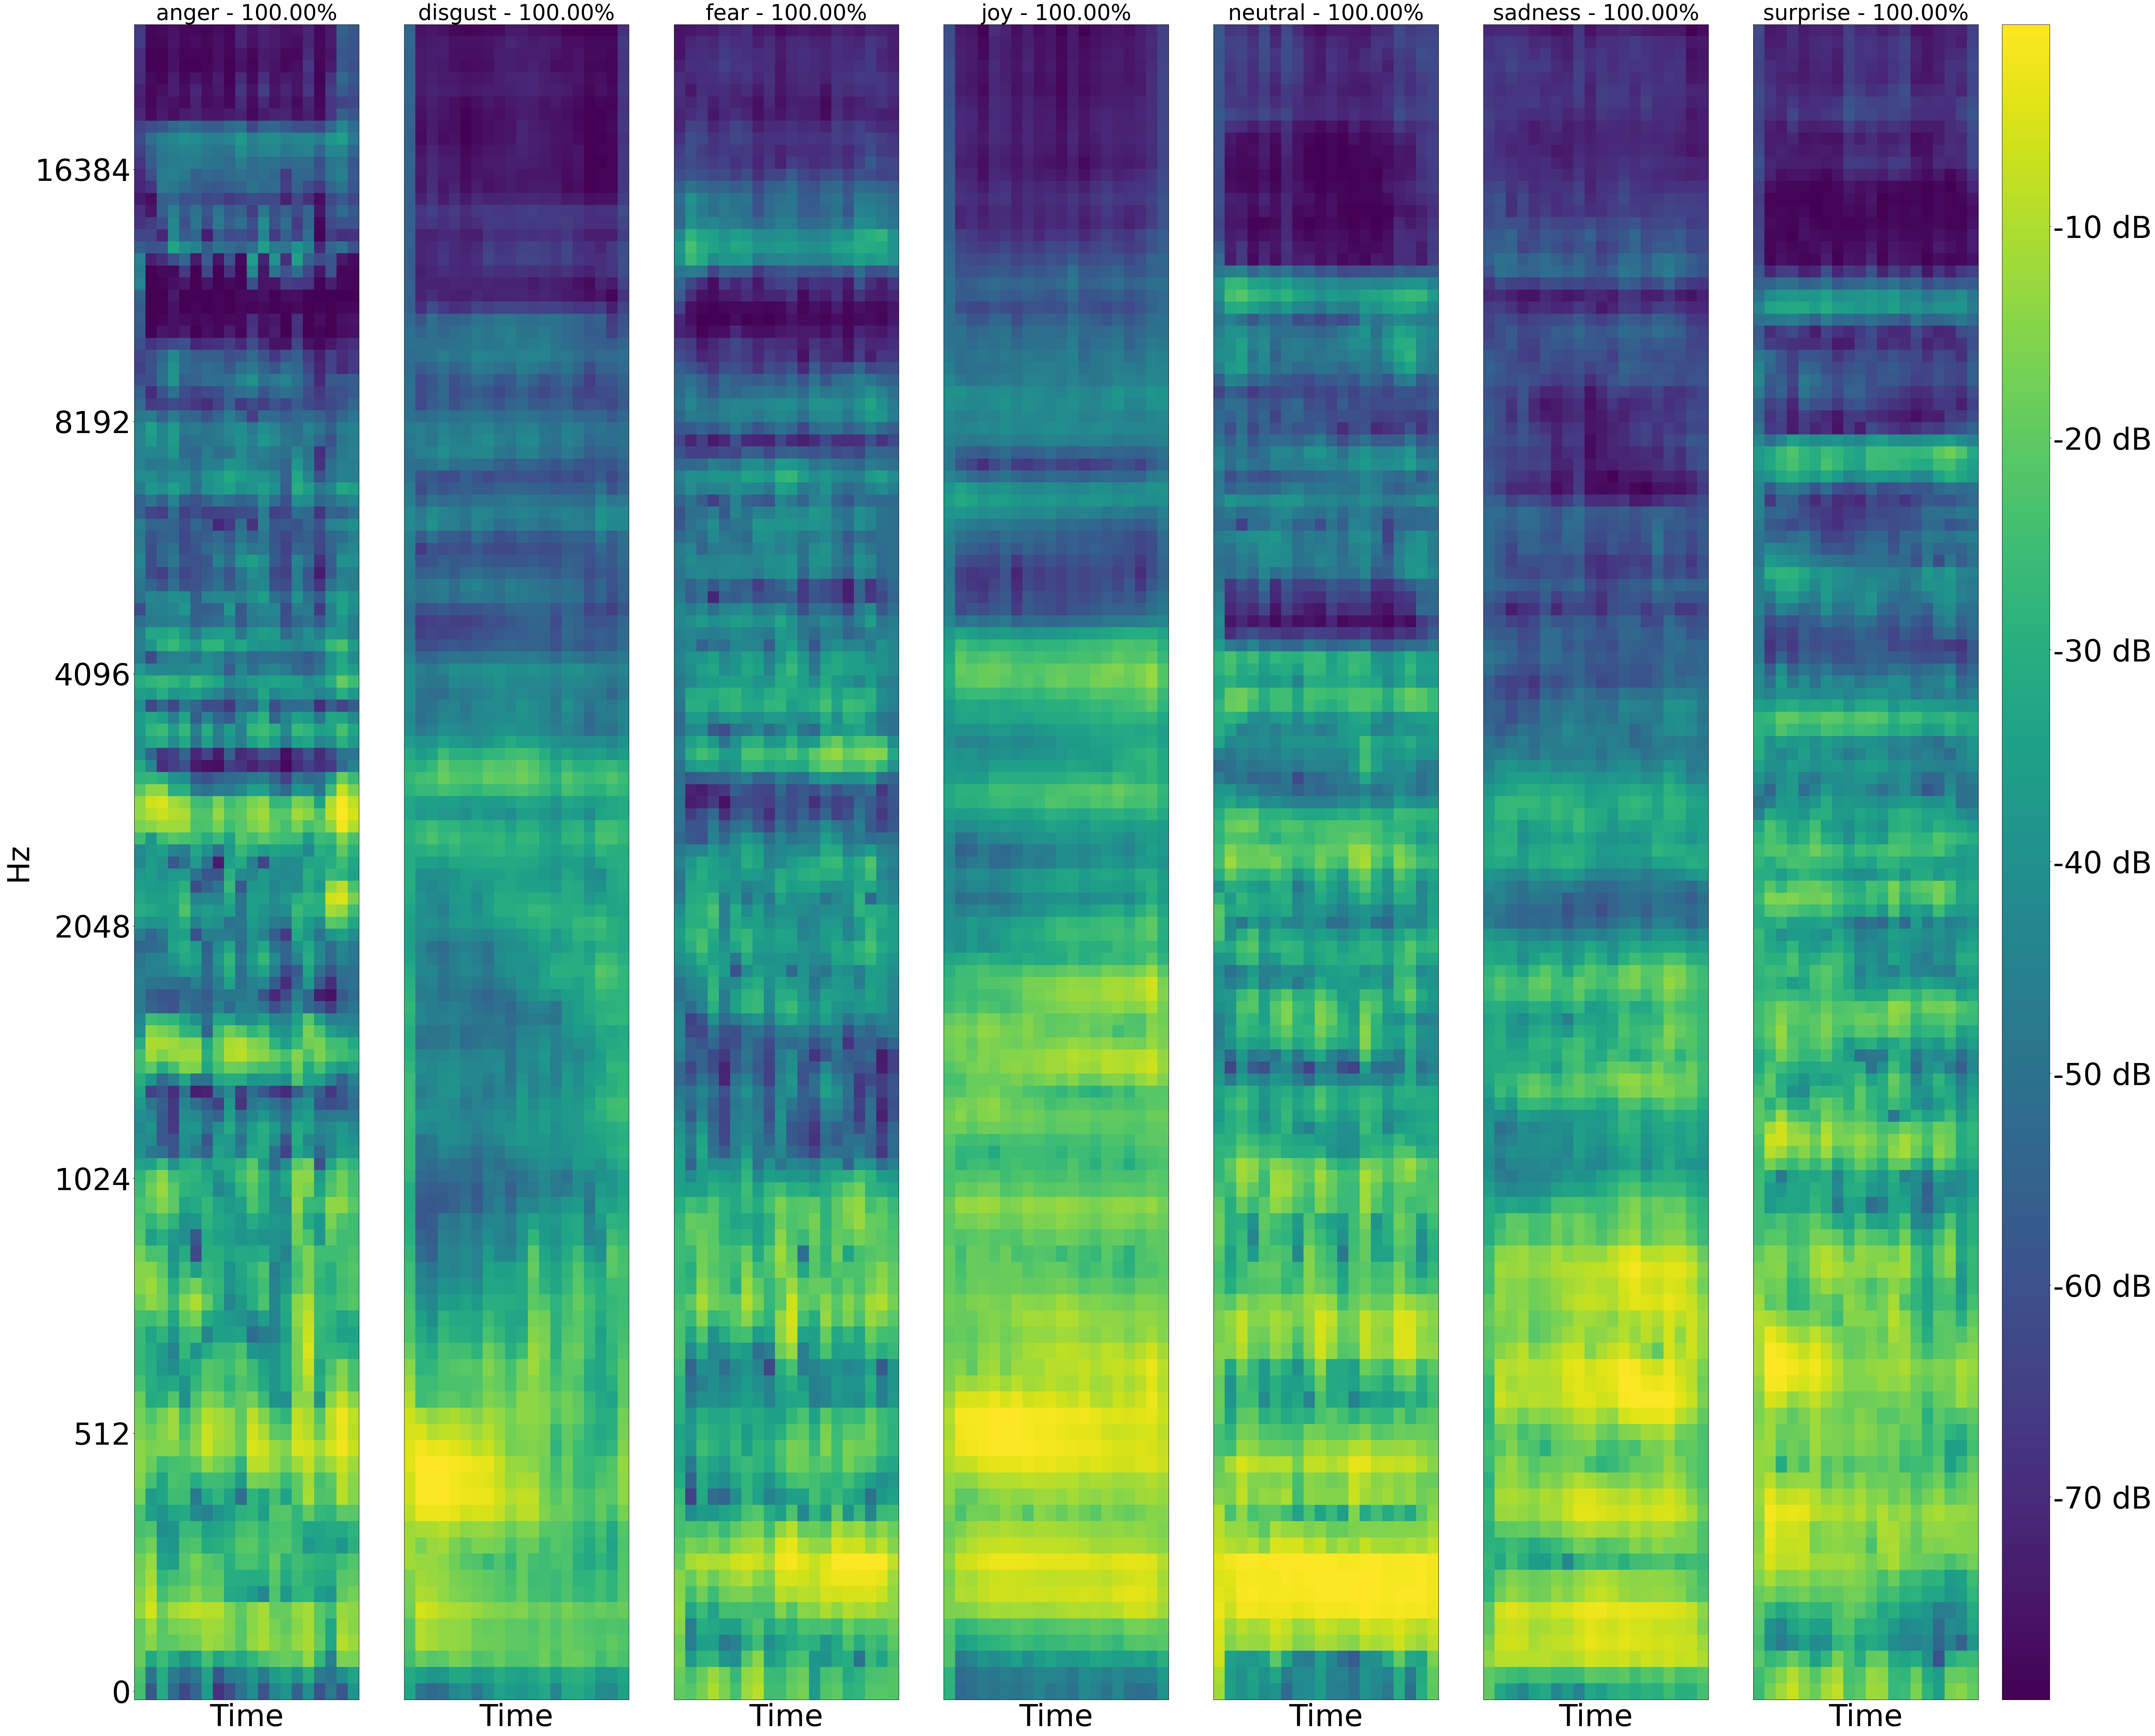

✅ Finished analyzing Speaker 07.


🔁 Analyzing Prototypes of Speaker 37...
Number of prototypes:  70
class anger : 10 prototypes
class disgust : 10 prototypes
class fear : 10 prototypes
class joy : 10 prototypes
class neutral : 10 prototypes
class sadness : 10 prototypes
class surprise : 10 prototypes


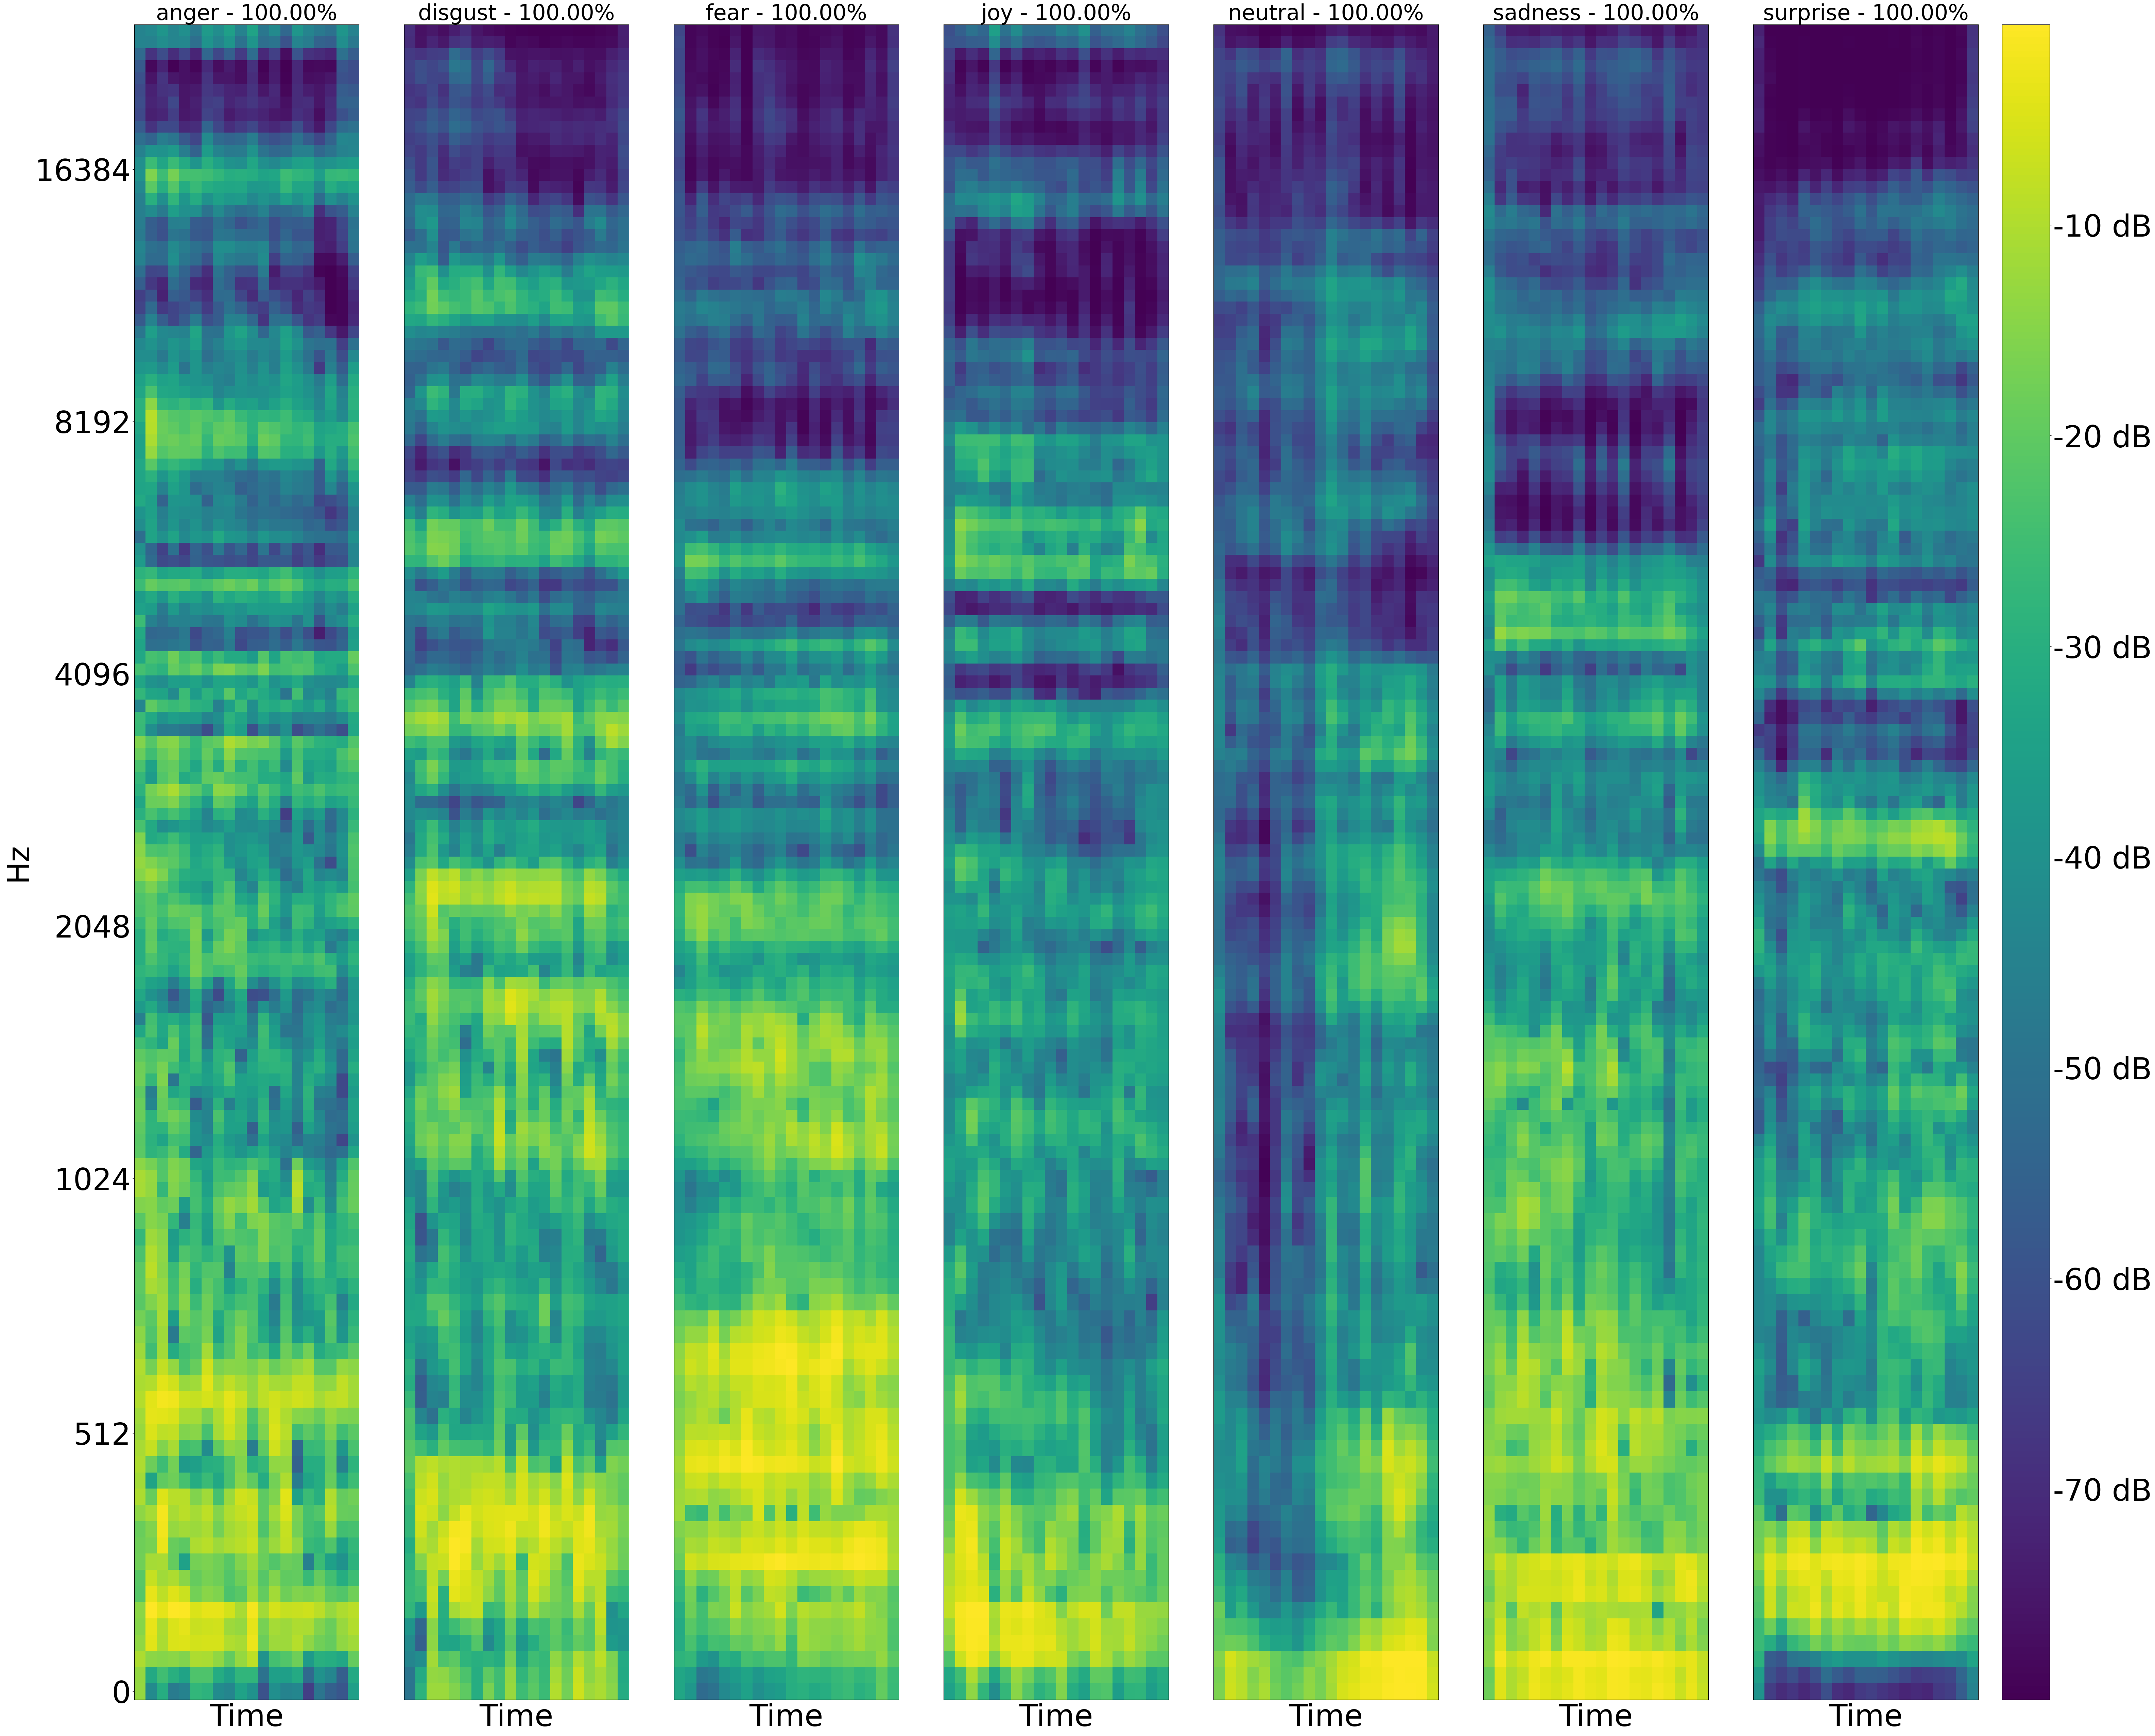

✅ Finished analyzing Speaker 37.


🔁 Analyzing Prototypes of Speaker 29...
Number of prototypes:  70
class anger : 10 prototypes
class disgust : 10 prototypes
class fear : 10 prototypes
class joy : 10 prototypes
class neutral : 10 prototypes
class sadness : 10 prototypes
class surprise : 10 prototypes


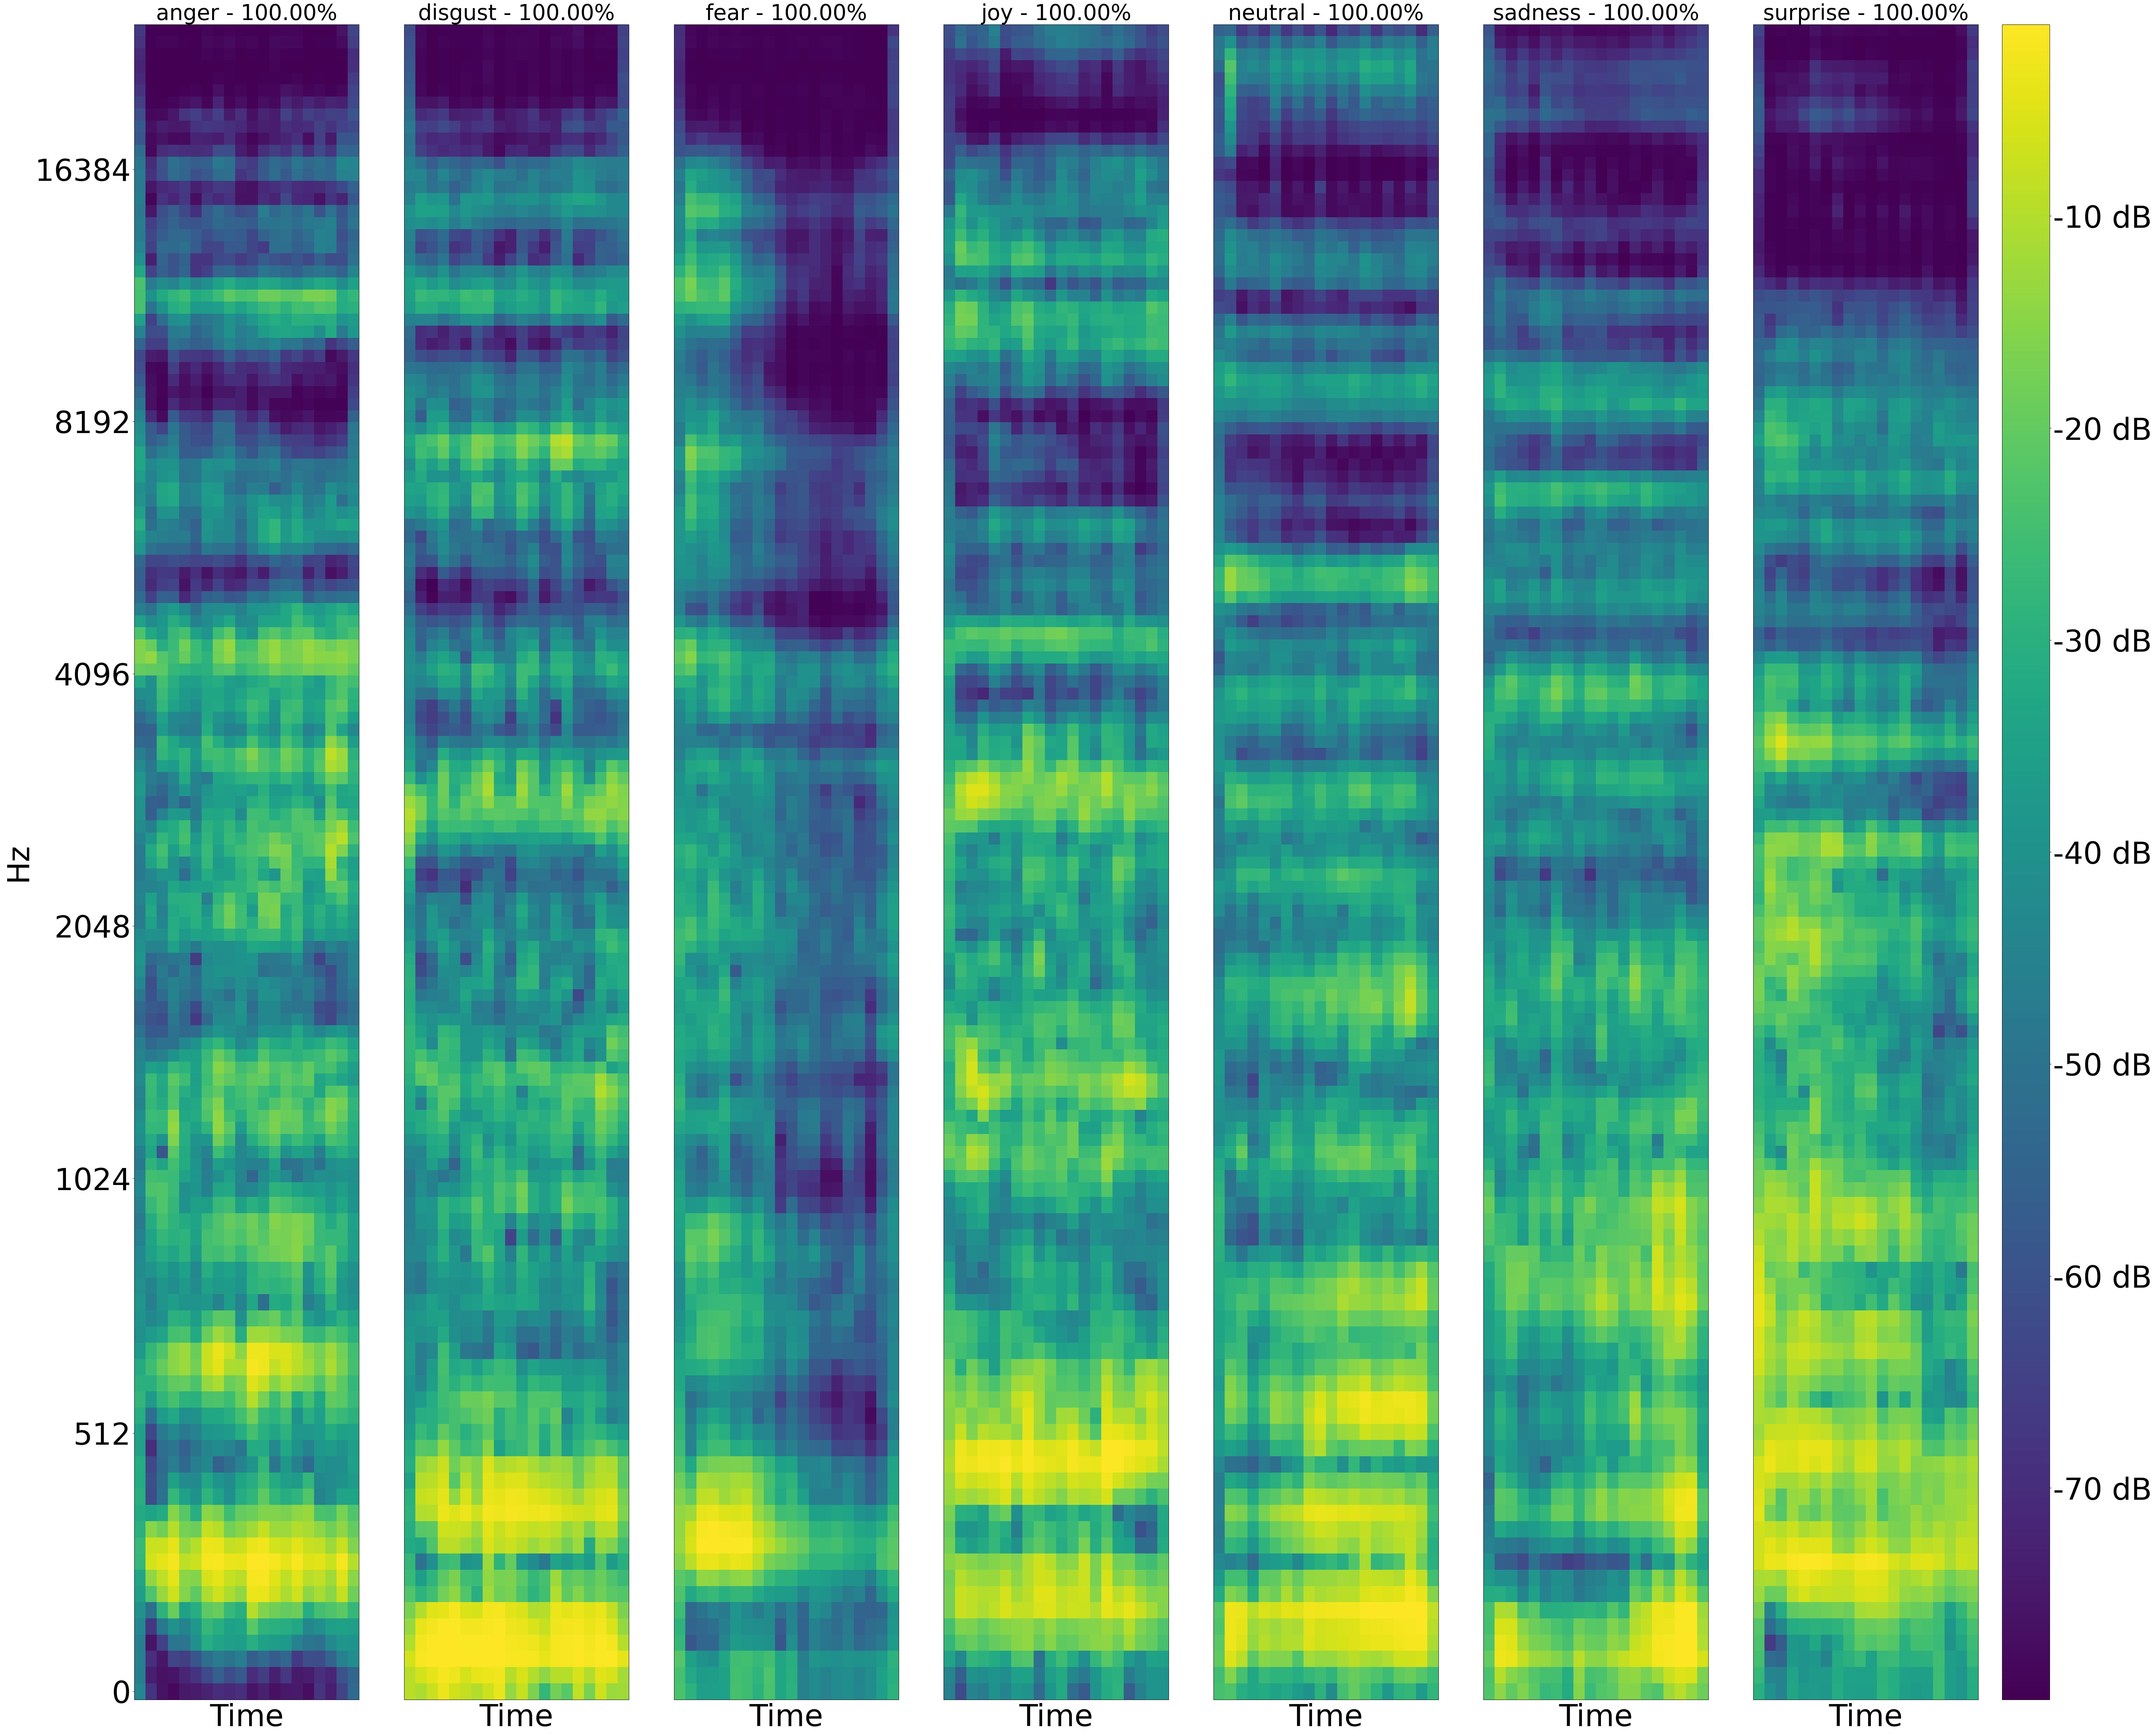

✅ Finished analyzing Speaker 29.


🔁 Analyzing Prototypes of Speaker 35...
Number of prototypes:  70
class anger : 10 prototypes
class disgust : 10 prototypes
class fear : 10 prototypes
class joy : 10 prototypes
class neutral : 10 prototypes
class sadness : 10 prototypes
class surprise : 10 prototypes


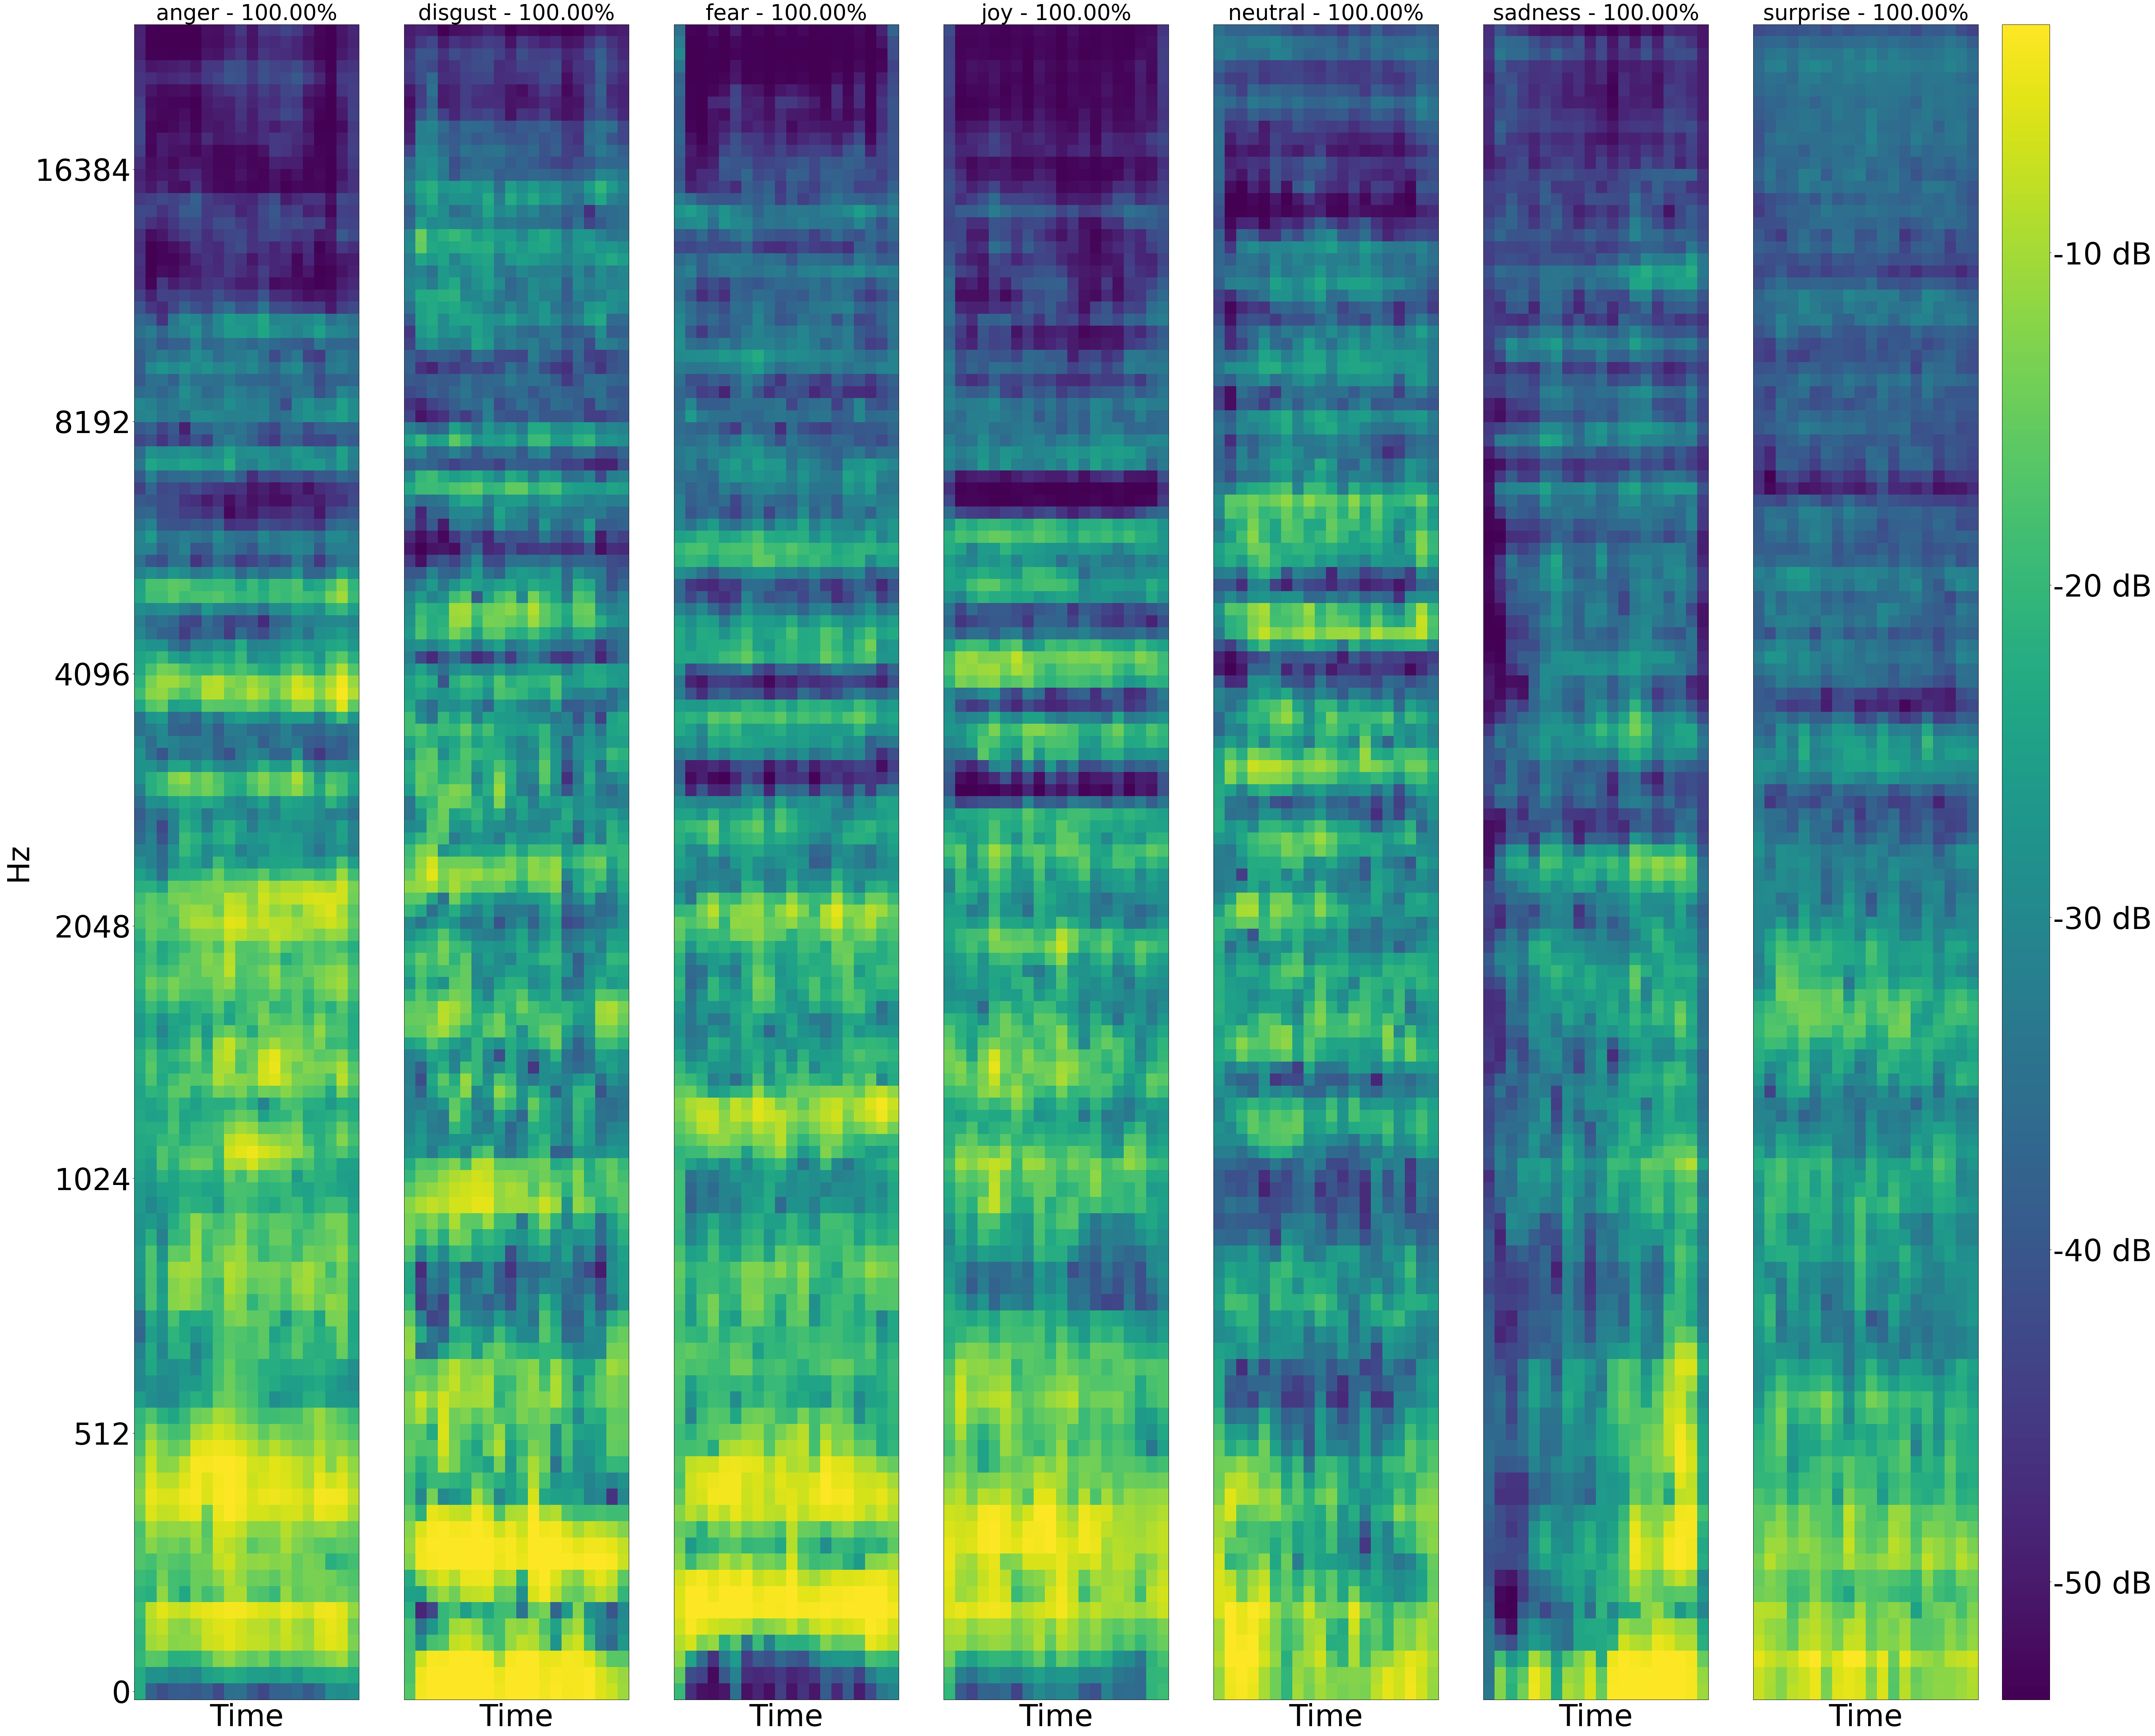

✅ Finished analyzing Speaker 35.


In [ ]:
# for speaker_id in range(1, n_speakers + 1):
for speaker_id in speakers:
    speaker = f"{speaker_id:02d}"  # format as '01', '02', ..., '50'
    print(f"\n\n🔁 Analyzing Prototypes of Speaker {speaker}...")

    # Define paths
    data_path = f'/home/jovyan/Daniel/Exp_{dataset}/datasets/{dataset}100ms32LabeledSpe{speaker}.npz'

    # Load data
    data = np.load(data_path)
    x_train_100ms = data['x_train']
    y_train_100ms = data['y_emo']

    x_train, x_test, y_train, y_test = train_test_split(
        x_train_100ms, y_train_100ms, test_size=test_prctg, random_state=42)

    # Preprocessing
    min_norm = np.min(x_train)
    max_norm = np.max(x_train)

    x_train_norm = (x_train - min_norm) / (max_norm - min_norm)
    x_test_norm = (x_test - min_norm) / (max_norm - min_norm)

    n_frames_cnn = x_train.shape[1]
    n_freq_cnn = x_train.shape[2]

    n_frames_enc = 64
    n_freq_enc = 10
    n_color_enc = 4

    if method == 'threshold':
      prototypes, weights = import_and_prune_prototypes_threshold(complete_speakers=[speaker_id], threshold=threshold, scoring_method=2)
    elif method == 'top':
      prototypes, weights = import_and_prune_prototypes_top(complete_speakers=[speaker_id], topN=topN, scoring_method=2)

    prototypes_rescaled = prototypes * (max_norm - min_norm) + min_norm
    weightsAux = weights

    maxs_prctg = []
    vals_prctg = []
    for row_prctg in weights:
        max_index_prctg = np.argmax(row_prctg)
        max_value_prctg = row_prctg[max_index_prctg]
        maxs_prctg.append(max_index_prctg)
        vals_prctg.append(max_value_prctg)

    print('Number of prototypes: ', prototypes_rescaled.shape[0])
    for class_val in range(n_classes):
        final_prototypes_for_class = [proto for proto, max_val in zip(prototypes, maxs_prctg) if max_val == class_val]
        prototype_confidences = [conf for conf, max_val in zip(vals_prctg, maxs_prctg) if max_val == class_val]
        num_prototypes_for_class = len(final_prototypes_for_class)
        prototypes_for_class = [proto for proto, max_val in zip(prototypes, maxs_prctg) if max_val == class_val]
        print('class', get_prototype_emotion.get(class_val), ':', num_prototypes_for_class, 'prototypes')


    # Save prototypes
    displayBestNPrototypesPerClass(num=1,
                  prototypes=prototypes_rescaled,
                  weights=weights,
                  freq_dep_dist=False,
                  n_prototypes=prototypes_rescaled.shape[0],
                  n_frames_enc=n_frames_enc,
                  n_freq_enc=n_freq_enc,
                  n_color_enc=n_color_enc,
                  n_frames_cnn=n_frames_cnn,
                  n_freq_cnn=n_freq_cnn,
                  epoch=0,
                  scale='Hz',
                  size='big')

    store_prototypes_imgs_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/'
    savePrototypes(path = store_prototypes_imgs_path,
                   prototypes=prototypes_rescaled,
                   weights=weights,
                   n_prototypes=prototypes.shape[0],
                   n_frames_cnn=prototypes.shape[1],
                   n_freq_cnn=prototypes.shape[2],
                   epoch=0,
                   scale='Hz',
                   emotions_per_rows=True,
                   size = 'big',
                   final = True,
                   colorbar = True,
                   overlay_f0 = False,
                   y_list = None,
                   fmin = fmin,
                   fmax = fmax)

    store_prototypes_audios_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/audioPrototypes/'
    y_list = saveAudioPrototypes(path = store_prototypes_audios_path,
                                 prototypes = prototypes_rescaled,
                                 weights = weights)

    # Save prototypes WITH f0 OVERLAYED
    store_prototypes_imgs_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/{speaker}/threshold{threshold}/'
    savePrototypes(path = store_prototypes_imgs_path,
                   prototypes=prototypes_rescaled,
                   weights=weights,
                   n_prototypes=prototypes.shape[0],
                   n_frames_cnn=prototypes.shape[1],
                   n_freq_cnn=prototypes.shape[2],
                   epoch=0,
                   scale='Hz',
                   emotions_per_rows=True,
                   size = 'small',
                   final = True,
                   colorbar = True,
                   y_list = y_list,
                   fmin = fmin,
                   fmax = fmax,
                   add_text = True,
                   overlay_f0 = True)

    mean_proto_score = get_mean_prototype_score(weightsAux)

    # Dictionary to store prototypes and scores for each class
    class_prototype_sets = defaultdict(list)

    # Iterate over prototypes and their assigned classes
    for proto, score, class_index in zip(prototypes_rescaled, vals_prctg, maxs_prctg):
        class_prototype_sets[class_index].append((proto, score))

    # Convert lists to NumPy arrays for easier analysis
    for class_index in class_prototype_sets:
        class_prototype_sets[class_index] = np.array(class_prototype_sets[class_index], dtype=object)

    for class_index in sorted(class_prototype_sets.keys()):
        prototypes = class_prototype_sets[class_index]
        num_prototypes = len(prototypes)
        avg_score = np.mean([p[1] for p in prototypes])
        print(f"Class {class_index} ({get_prototype_emotion[class_index]}): {num_prototypes} prototypes, Avg confidence: {avg_score:.2f}%")

    # Create f0 report
    report_type = 'f0'
    report_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    generate_f0_report(prototypes_rescaled, maxs_prctg, vals_prctg, y_list,
                       get_prototype_emotion, n_classes, class_prototype_sets,
                       dataset=dataset, speaker=speaker, threshold=threshold,
                       sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
                       pdf_path=report_path)

    # Create classwise report
    report_type = 'classwise'
    report_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    generate_classwise_report(
        n_classes=n_classes,
        class_prototype_sets=class_prototype_sets,
        get_prototype_emotion=get_prototype_emotion,
        dataset=dataset,
        speaker=speaker,
        mel_bin_frequencies=mel_bin_frequencies,
        analyze_input_class_for_report=analyze_input_class_for_report,
        analyze_prototype_for_report=analyze_prototype_for_report,
        analyze_prototype_class_for_report=analyze_prototype_class_for_report,
        pdf_path=report_path)

    # Create prototypes_top_frequencies report
    report_type = 'prototypes_top_frequencies'
    report_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    results = analyze_prototypes_only_comparison(prototypes_rescaled, weights)
    generate_prototype_pdf_report_by_class(results, mel_bin_frequencies,
                                           class_prototype_sets,
                                           output_path=report_path)

    # Create classes_top_frequencies report
    report_type = 'classes_top_frequencies'
    class_summary_pdf_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    number_of_notes = 10
    results = analyze_prototypes_only_comparison(prototypes_rescaled, weights)
    generate_class_summary_top_frequencies(results, mel_bin_frequencies, class_prototype_sets, output_path=class_summary_pdf_path)

    output_dir = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/{speaker}/threshold{threshold}'
    number_of_notes = 10
    results = analyze_prototypes_only_comparison(prototypes_rescaled, weights)
    generate_class_summary_top_frequencies_boxplots(results, mel_bin_frequencies, class_prototype_sets, output_dir=output_dir)

    output_dir = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/{speaker}/threshold{threshold}'
    number_of_notes = 10
    results = analyze_prototypes_only_comparison(prototypes_rescaled, weights)
    generate_all_classes_summary_plot(results, mel_bin_frequencies, class_prototype_sets, output_dir=output_dir, prototypes_rescaled=prototypes_rescaled, freq_range=(0, 2000), speaker=speakerNumber)

    # Create prototypes_pitch_notes report
    report_type = 'prototypes_pitch_notes'
    report_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    generate_prototypes_pitch_notes_report(
        class_prototype_sets=class_prototype_sets,
        prototypes_rescaled=prototypes_rescaled,
        get_prototype_emotion=get_prototype_emotion,
        analyze_pitch_notes=analyze_pitch_notes,
        dataset=dataset, speaker=speaker, sr=sr, pdf_path=report_path)

    # Create classes_pitch_notes report
    report_type = 'classes_pitch_notes'
    summary_class_notes_report_path = f'/home/jovyan/Daniel/Exp_{dataset}/prototype_analysis/PRUNED/Speaker{speaker}/{report_type}_report.pdf'
    number_of_notes = 10
    class_notes_dict = extract_notes_from_prototypes(speaker, class_prototype_sets)

    # Create summary PDF
    with PdfPages(summary_class_notes_report_path) as pdf:
        for class_index, notes_list in class_notes_dict.items():
            note_counts = Counter(notes_list)
            top_notes = note_counts.most_common(number_of_notes)

            labels, values = zip(*top_notes) if top_notes else ([], [])
            plt.figure(figsize=(10, 4))
            plt.bar(labels, values, color='skyblue')
            plt.title(f"Class {class_index} ({get_prototype_emotion[class_index]})\nMost Frequent Notes")
            plt.xlabel("Note")
            plt.ylabel("Count")
            plt.grid(True, axis='y', linestyle='--', alpha=0.5)
            plt.tight_layout()
            pdf.savefig()
            plt.close()

    print(f"\n✅ Summary note report saved as: {summary_class_notes_report_path}")

    print(f"✅ Finished analyzing Speaker {speaker}.")